# Variational Autoencoders

Author: **Duncan Kirby**

Adapted from https://github.com/altosaar/variational-autoencoder/blob/master/train_variational_autoencoder_tensorflow.py



## First import everything we need

In [17]:
import itertools
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import time
import seaborn as sns

from matplotlib import pyplot as plt
from imageio import imwrite
import imageio.core.util
# Patch unecessary imageio warning 
def silence_imageio_warning(*args, **kwargs):
    pass
imageio.core.util._precision_warn = silence_imageio_warning

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

sns.set_style('whitegrid')

distributions = tf.distributions

## Now define hyperparameters

In [18]:
vae_global_parameters = {'data_dir': os.path.join(os.getcwd(),'/tmp/dat/'),
                         'logdir': os.path.join(os.getcwd(),'/tmp/log/'),
                         'latent_dim': 2,
                         'batch_size': 64, # Minibatch size 
                         'n_samples': 10, # Number of samples to save
                         'print_every': 10, # Print every n iterations
                         'hidden_size': 200, # Hidden size for neural networks
                         'n_iterations': 1000} # number of iterations

# For bigger model:
#'latent_dim': 100,
#'batch_size': 64,
#'n_samples': 1,
#'print_every': 1000,
#'hidden_size': 200,
#'n_iterations': 100000

## Let's build an encoder

We choose two latent variables, $\mu$ and $\sigma$, described via a neural net with 200 nodes per hidden layer.

In [19]:

def encoder(x, latent_dim=vae_global_parameters['latent_dim'], hidden_size=vae_global_parameters['hidden_size']):
  """Construct an inference network parametrizing a Gaussian.
  Args:
    x: A batch of MNIST digits.
    latent_dim: The latent dimensionality.
    hidden_size: The size of the neural net hidden layers.
  Returns:
    mu: Mean parameters for the variational family Normal (dim=2)
    sigma: Standard deviation parameters for the variational family Normal (dim=2x2 with 0 off-diagonal components)
  """
  # this line simplifies the tensorflow implementation of a fully connected layer by filling in all the parameters in the call
  # to tf.contrib.layers.fully_connected() with default values:
  with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu): 
    net = slim.flatten(x) # first thing this net does is flatten the input image into a column vector
    net = slim.fully_connected(net, hidden_size) # adds a fully connected layer to the net
    net = slim.fully_connected(net, hidden_size)
    gaussian_params = slim.fully_connected(net, latent_dim * 2, activation_fn=None)
  # The mean parameter is unconstrained so just take the values for the 2-vector mu
  mu = gaussian_params[:, :latent_dim]
  # The standard deviation must be positive. Parametrize with a softplus
  sigma = tf.nn.softplus(gaussian_params[:, latent_dim:])
  return mu, sigma


## We'll also build a decoder

In [20]:

def decoder(z, hidden_size=vae_global_parameters['hidden_size']):
  """Build a generative network parametrizing the likelihood of the data
  Args:
    z: Samples of latent variables
    hidden_size: Size of the hidden state of the neural net
  Returns:
    bernoulli_logits: logits for the Bernoulli likelihood of the data
                        ie. probability of pixel value being 1 is p, probability of being 0 is 1-p
  """
  with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
    net = slim.fully_connected(z, hidden_size)
    net = slim.fully_connected(net, hidden_size)
    bernoulli_logits = slim.fully_connected(net, 784, activation_fn=None)
    bernoulli_logits = tf.reshape(bernoulli_logits, [-1, 28, 28, 1])
  return bernoulli_logits


## Finally, we'll define the training scheme

In [21]:

def train():
  # Train a Variational Autoencoder on MNIST

  # Input placeholders
  with tf.name_scope('data'): # another context manager
    x = tf.placeholder(tf.float32, [None, 28, 28, 1])
    tf.summary.image('data', x)

  with tf.variable_scope('variational'):
    # ------------------#
    # KEY IDEA NUMBER 1
    # ------------------#    
    # The variational distribution is a Normal with mean and standard deviation given by the inference network
    q_mu, q_sigma = encoder(x=x,
                            latent_dim=vae_global_parameters['latent_dim'],
                            hidden_size=vae_global_parameters['hidden_size'])
    q_z = distributions.Normal(loc=q_mu, scale=q_sigma)
    # ------------------#
    
    
    
    # The next line just allows gradients to be taken later
    assert q_z.reparameterization_type == distributions.FULLY_REPARAMETERIZED 

  with tf.variable_scope('model'):
    # ------------------#
    # KEY IDEA NUMBER 2
    # ------------------#
    # The likelihood is Bernoulli-distributed (ie. pixels are 0 or 1) with 
    # probability for drawing 1 given by the generative network (recall probability for drawing 0 is then 1-p(1) )
    p_x_given_z_logits = decoder(z=q_z.sample(),hidden_size=vae_global_parameters['hidden_size'])
    p_x_given_z = distributions.Bernoulli(logits=p_x_given_z_logits)
    
    posterior_predictive_samples = p_x_given_z.sample()
    # ------------------#
    
    
    tf.summary.image('posterior_predictive',
                     tf.cast(posterior_predictive_samples, tf.float32))

  # Take samples from the prior
  with tf.variable_scope('model', reuse=True):
    # ------------------#
    # KEY IDEA NUMBER 3
    # ------------------#
    p_epsilon = distributions.Normal(loc=np.zeros(vae_global_parameters['latent_dim'], dtype=np.float32),
                               scale=np.ones(vae_global_parameters['latent_dim'], dtype=np.float32))
    
    p_epsilon_sample = p_epsilon.sample(vae_global_parameters['n_samples'])
    p_x_given_z_logits = decoder(z=p_epsilon_sample,hidden_size=vae_global_parameters['hidden_size'])
    prior_predictive = distributions.Bernoulli(logits=p_x_given_z_logits)
    prior_predictive_samples = prior_predictive.sample()
    # ------------------#
    
    
    tf.summary.image('prior_predictive',
                     tf.cast(prior_predictive_samples, tf.float32))

  # Take samples from the prior with a placeholder
  with tf.variable_scope('model', reuse=True):
    z_input = tf.placeholder(tf.float32, [None, vae_global_parameters['latent_dim']])
    p_x_given_z_logits = decoder(z=z_input,hidden_size=vae_global_parameters['hidden_size'])
    prior_predictive_inp = distributions.Bernoulli(logits=p_x_given_z_logits)
    prior_predictive_inp_sample = prior_predictive_inp.sample()

  # Build the evidence lower bound (ELBO) or the negative loss
  
  # ------------------#
  # KEY IDEA NUMBER 4
  # ------------------#
  kl = tf.reduce_sum(distributions.kl_divergence(q_z, p_epsilon), 1)
  expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x),[1, 2, 3])

  elbo = tf.reduce_sum(expected_log_likelihood - kl, 0)

  optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

  # minimizing -ELBO is maximizing ELBO
  train_op = optimizer.minimize(-elbo)
  # ------------------#


  # Merge all the summaries
  summary_op = tf.summary.merge_all()

  init_op = tf.global_variables_initializer()

  # Run training
  sess = tf.InteractiveSession()
  sess.run(init_op)

  mnist = read_data_sets(vae_global_parameters['data_dir'], one_hot=True)

  print('Saving TensorBoard summaries and images to: %s' % vae_global_parameters['logdir'])
  train_writer = tf.summary.FileWriter(vae_global_parameters['logdir'], sess.graph)

  # Get fixed MNIST digits for plotting posterior means during training
  np_x_fixed, np_y = mnist.test.next_batch(5000)
  np_x_fixed = np_x_fixed.reshape(5000, 28, 28, 1)
  np_x_fixed = (np_x_fixed > 0.5).astype(np.float32)

  t0 = time.time()
  for i in range(vae_global_parameters['n_iterations']):
    # Re-binarize the data at every batch; this improves results
    np_x, _ = mnist.train.next_batch(vae_global_parameters['batch_size'])
    np_x = np_x.reshape(vae_global_parameters['batch_size'], 28, 28, 1)
    np_x = (np_x > 0.5).astype(np.float32)
    sess.run(train_op, {x: np_x})

    # Print progress and save samples every so often
    if i % vae_global_parameters['print_every'] == 0:
      np_elbo, summary_str = sess.run([elbo, summary_op], {x: np_x})
      train_writer.add_summary(summary_str, i)
      print('Iteration: {0:d} ELBO: {1:.3f} s/iter: {2:.3e}'.format(
          i,
          np_elbo / vae_global_parameters['batch_size'],
          (time.time() - t0) / vae_global_parameters['print_every']))
      t0 = time.time()

      # Save samples
      np_posterior_samples, np_prior_samples = sess.run(
          [posterior_predictive_samples, prior_predictive_samples], {x: np_x})
      for k in range(vae_global_parameters['n_samples']):
        f_name = os.path.join(
            vae_global_parameters['logdir'], 'iter_%d_posterior_predictive_%d_data.jpg' % (i, k))
        imwrite(f_name, np_x[k, :, :, 0])
        f_name = os.path.join(
            vae_global_parameters['logdir'], 'iter_%d_posterior_predictive_%d_sample.jpg' % (i, k))
        imwrite(f_name, np_posterior_samples[k, :, :, 0])
        f_name = os.path.join(
            vae_global_parameters['logdir'], 'iter_%d_prior_predictive_%d.jpg' % (i, k))
        imwrite(f_name, np_prior_samples[k, :, :, 0])

      # Plot the posterior predictive space
      if vae_global_parameters['latent_dim'] == 2:
        np_q_mu = sess.run(q_mu, {x: np_x_fixed})
        cmap = mpl.colors.ListedColormap(sns.color_palette("husl"))
        f, ax = plt.subplots(1, figsize=(6 * 1.1618, 6))
        im = ax.scatter(np_q_mu[:, 0], np_q_mu[:, 1], c=np.argmax(np_y, 1), cmap=cmap,
                        alpha=0.7)
        ax.set_xlabel('First dimension of sampled latent variable $z_1$')
        ax.set_ylabel('Second dimension of sampled latent variable mean $z_2$')
        ax.set_xlim([-10., 10.])
        ax.set_ylim([-10., 10.])
        f.colorbar(im, ax=ax, label='Digit class')
        plt.tight_layout()
        plt.savefig(os.path.join(vae_global_parameters['logdir'],
                                 'posterior_predictive_map_frame_%d.png' % i))
        plt.close()

        nx = ny = 20
        x_values = np.linspace(-3, 3, nx)
        y_values = np.linspace(-3, 3, ny)
        canvas = np.empty((28 * ny, 28 * nx))
        for ii, yi in enumerate(x_values):
          for j, xi in enumerate(y_values):
            np_z = np.array([[xi, yi]])
            x_mean = sess.run(prior_predictive_inp_sample, {z_input: np_z})
            canvas[(nx - ii - 1) * 28:(nx - ii) * 28, j * 28:(j + 1) * 28] = x_mean[0].reshape(28, 28)
        imwrite(os.path.join(vae_global_parameters['logdir'], 'prior_predictive_map_frame_%d.png' % i), canvas)
        plt.figure(figsize=(8, 10))
        Xi, Yi = np.meshgrid(x_values, y_values)
        plt.imshow(canvas, origin="upper")
        plt.tight_layout()
        plt.savefig('latent_space.pdf')
        plt.show()
        plt.close()

Extracting C:/tmp/dat/train-images-idx3-ubyte.gz
Extracting C:/tmp/dat/train-labels-idx1-ubyte.gz
Extracting C:/tmp/dat/t10k-images-idx3-ubyte.gz
Extracting C:/tmp/dat/t10k-labels-idx1-ubyte.gz
Saving TensorBoard summaries and images to: C:/tmp/log/
Iteration: 0 ELBO: -539.496 s/iter: 5.492e-02


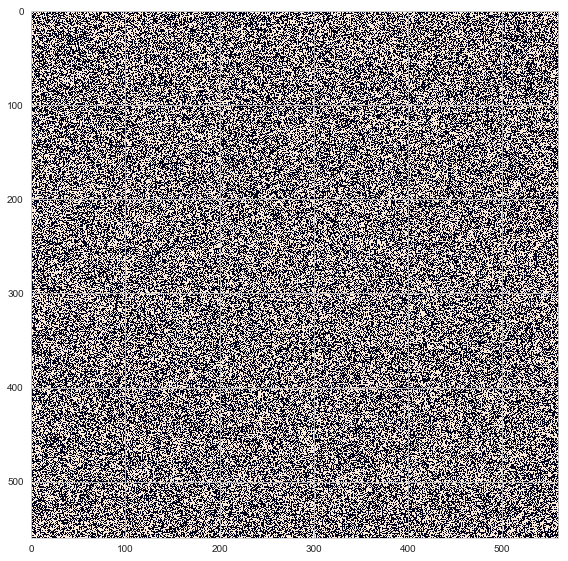

Iteration: 10 ELBO: -239.270 s/iter: 3.126e-01


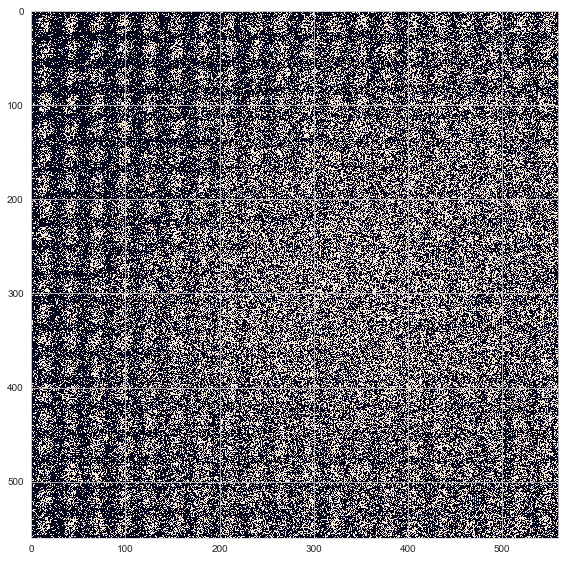

Iteration: 20 ELBO: -223.733 s/iter: 2.836e-01


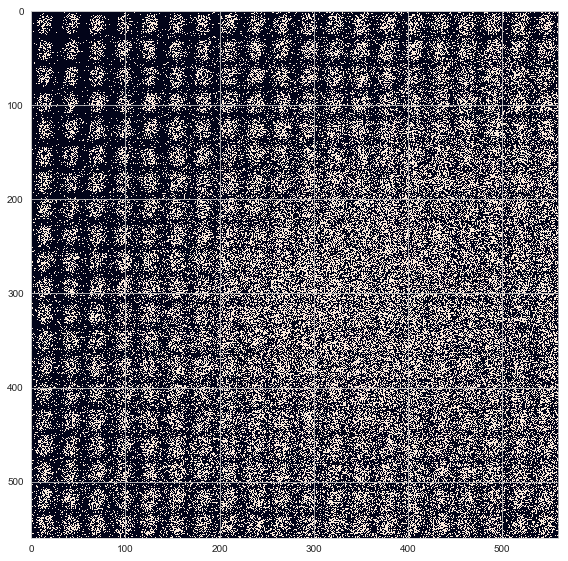

Iteration: 30 ELBO: -203.713 s/iter: 2.587e-01


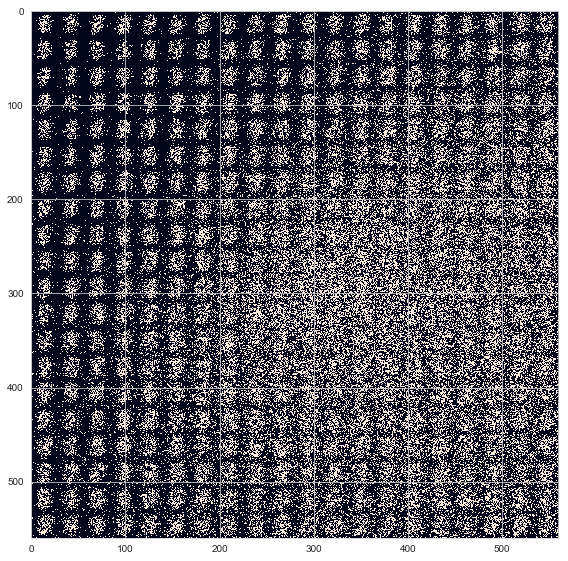

Iteration: 40 ELBO: -208.753 s/iter: 2.428e-01


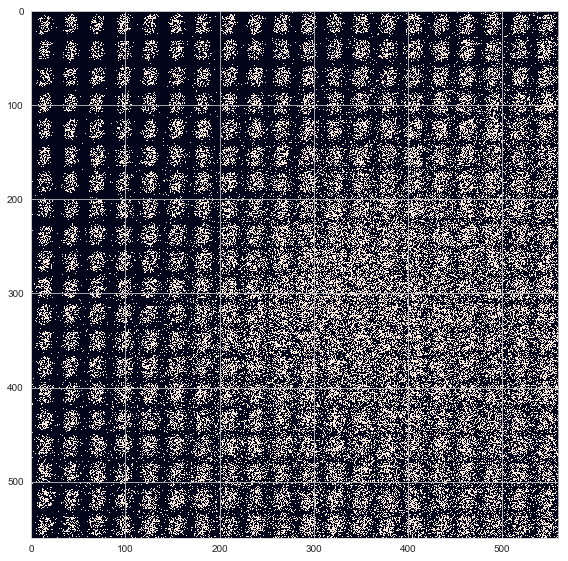

Iteration: 50 ELBO: -214.674 s/iter: 2.248e-01


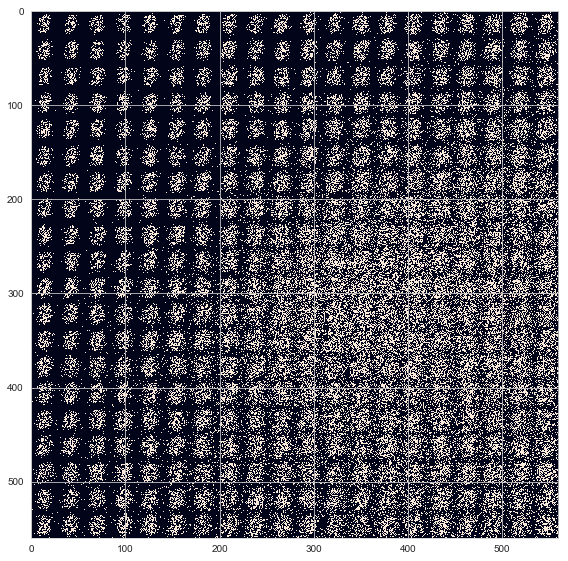

Iteration: 60 ELBO: -202.871 s/iter: 2.049e-01


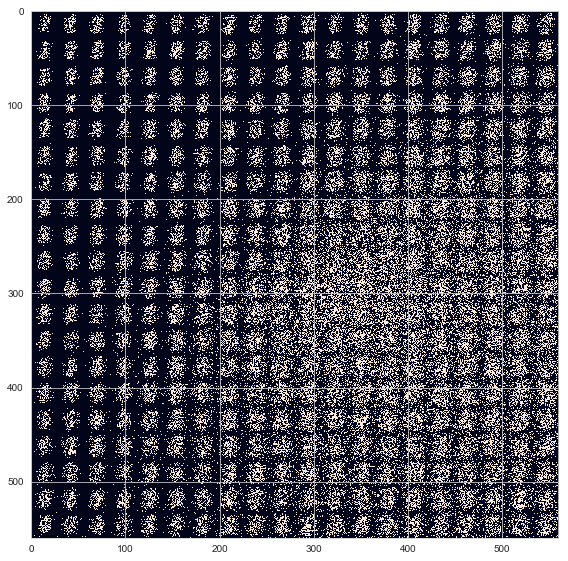

Iteration: 70 ELBO: -207.310 s/iter: 2.046e-01


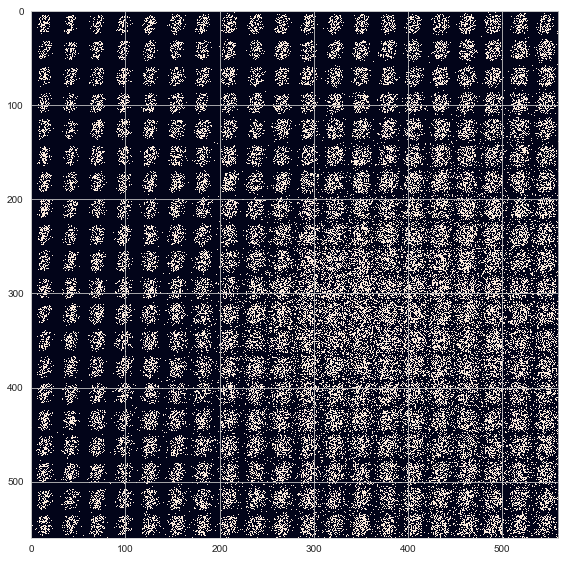

Iteration: 80 ELBO: -218.957 s/iter: 1.932e-01


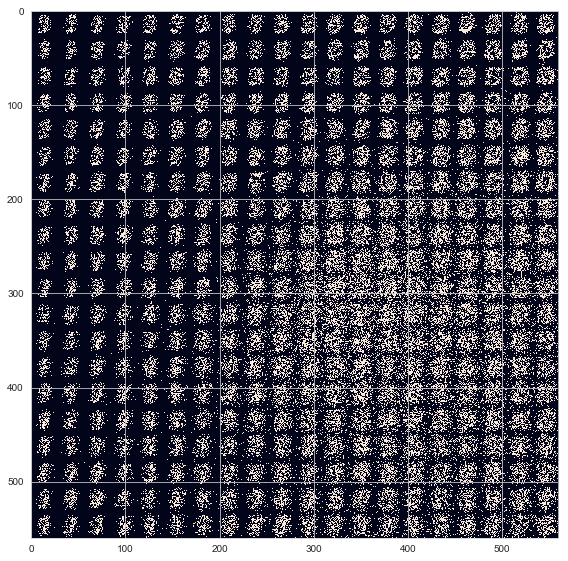

Iteration: 90 ELBO: -197.264 s/iter: 1.922e-01


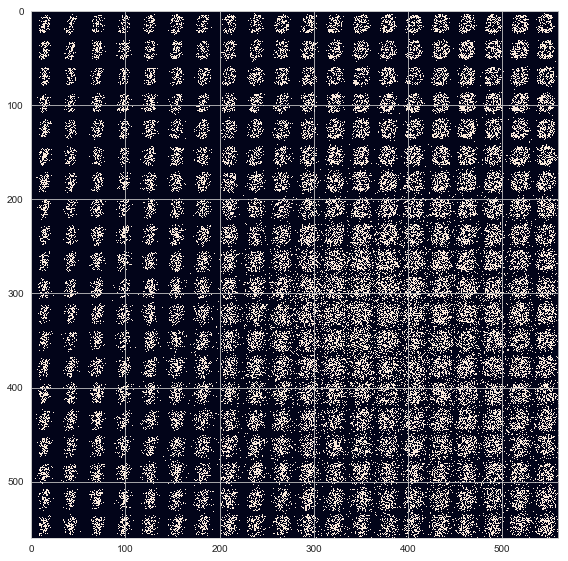

Iteration: 100 ELBO: -203.980 s/iter: 1.777e-01


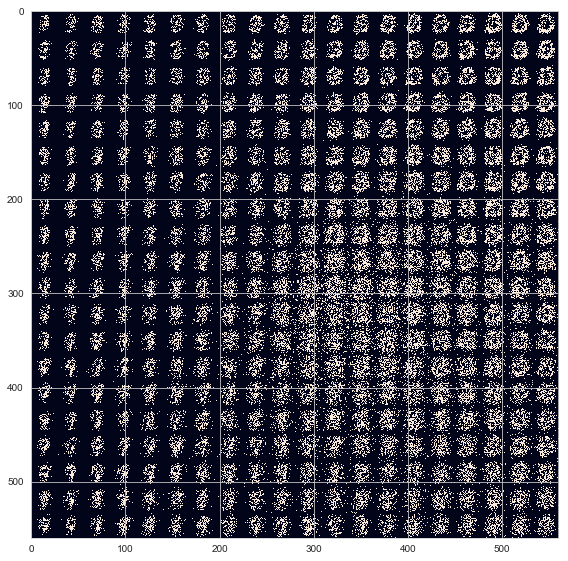

Iteration: 110 ELBO: -189.464 s/iter: 1.697e-01


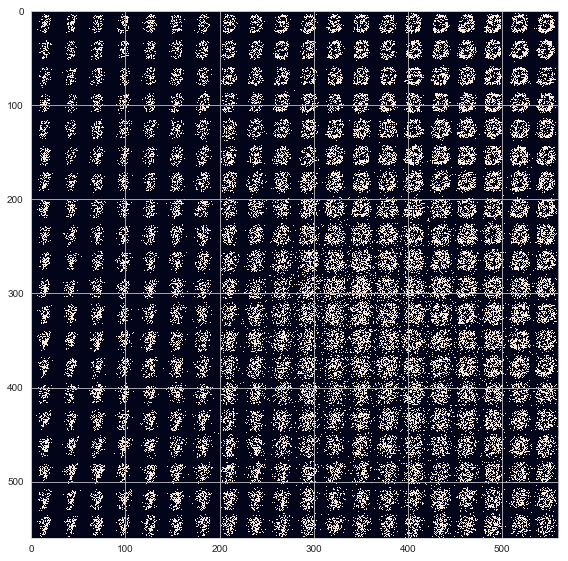

Iteration: 120 ELBO: -177.858 s/iter: 1.652e-01


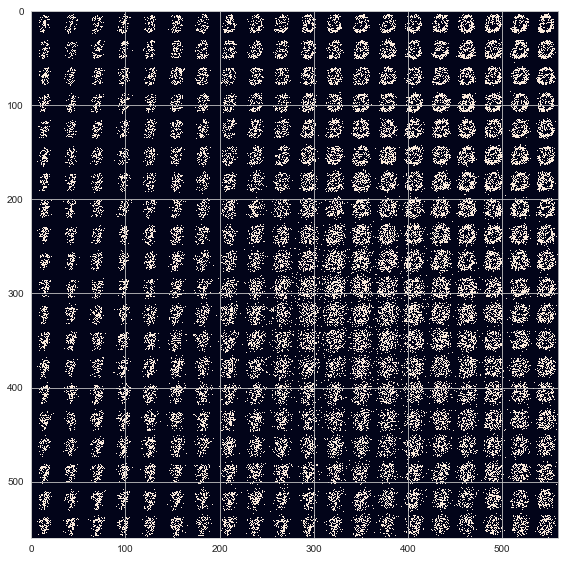

Iteration: 130 ELBO: -199.100 s/iter: 1.726e-01


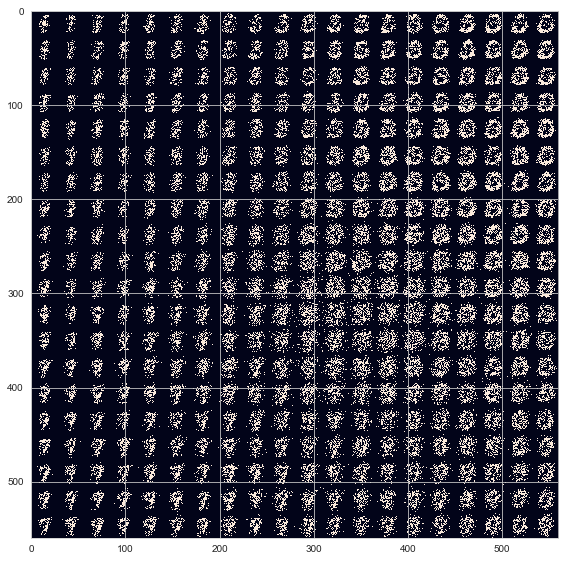

Iteration: 140 ELBO: -186.979 s/iter: 1.527e-01


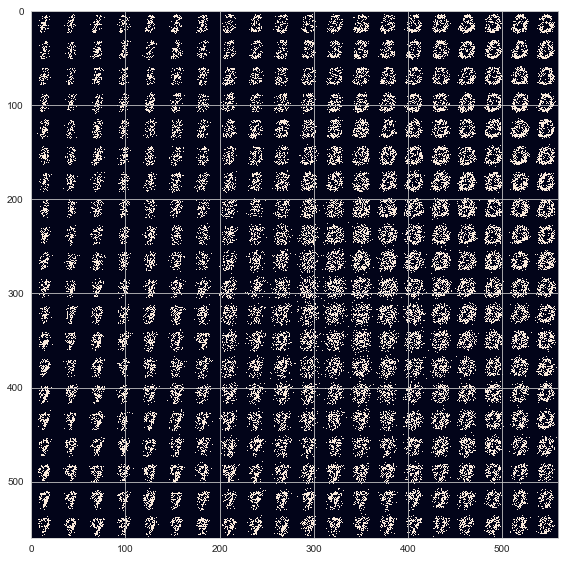

Iteration: 150 ELBO: -188.403 s/iter: 1.611e-01


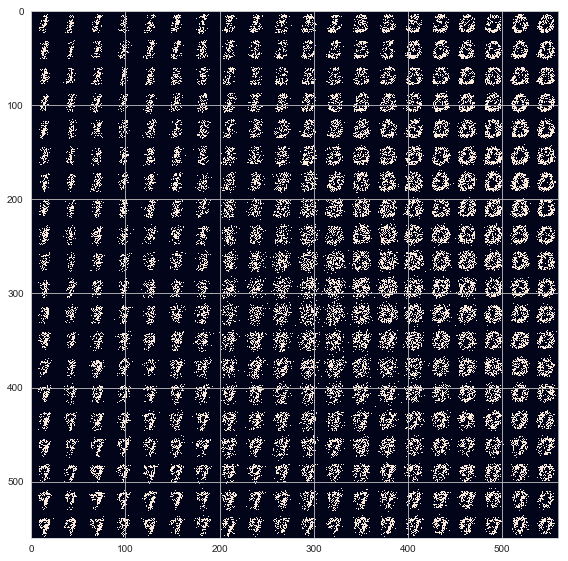

Iteration: 160 ELBO: -182.799 s/iter: 1.499e-01


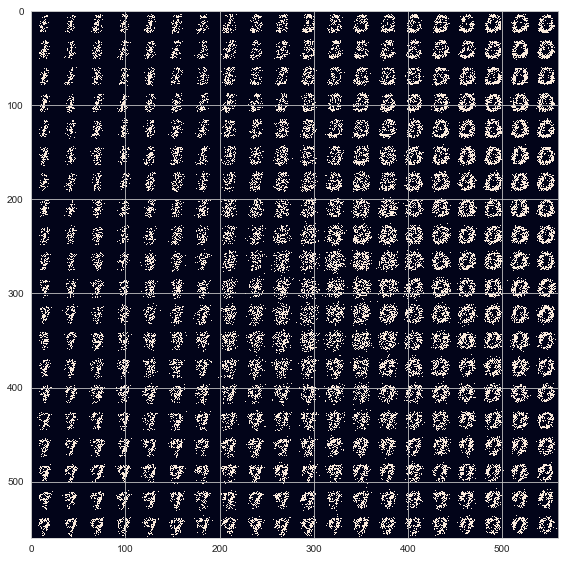

Iteration: 170 ELBO: -186.440 s/iter: 1.581e-01


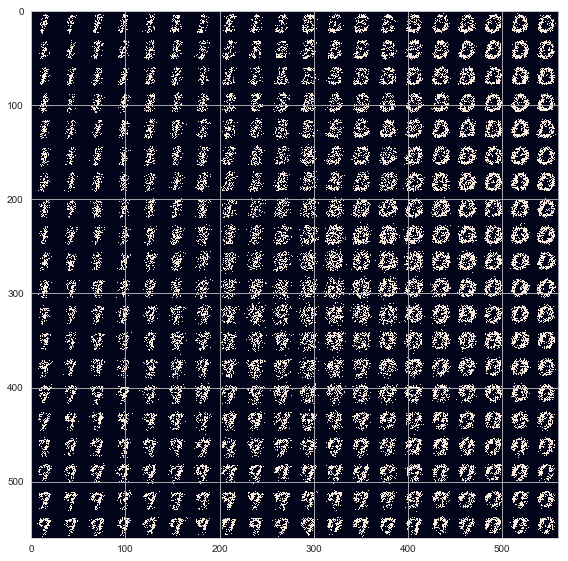

Iteration: 180 ELBO: -182.154 s/iter: 1.521e-01


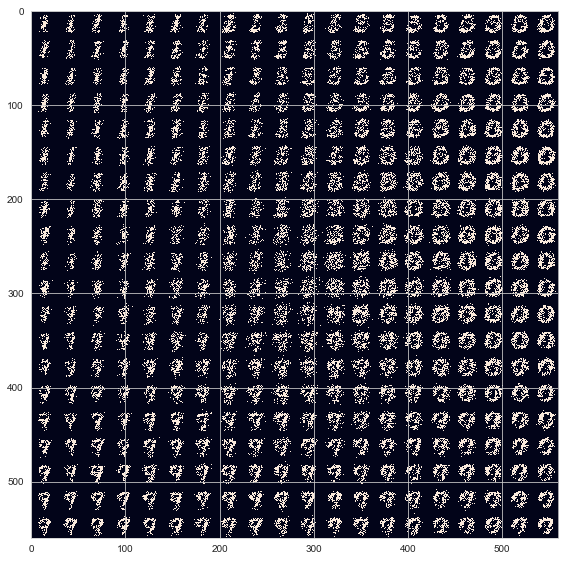

Iteration: 190 ELBO: -177.770 s/iter: 1.519e-01


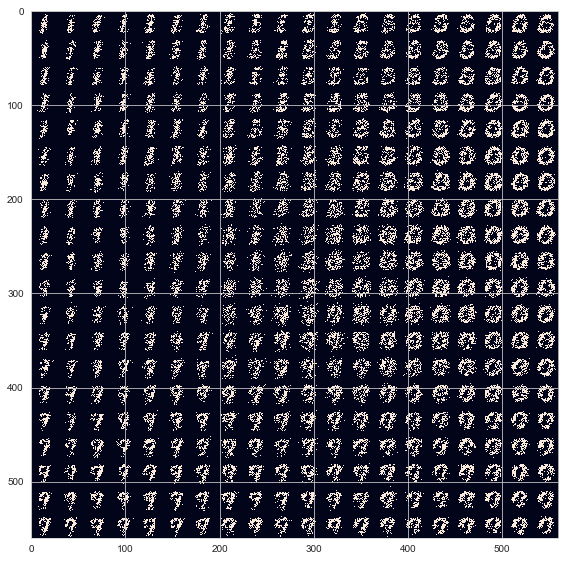

Iteration: 200 ELBO: -183.478 s/iter: 1.453e-01


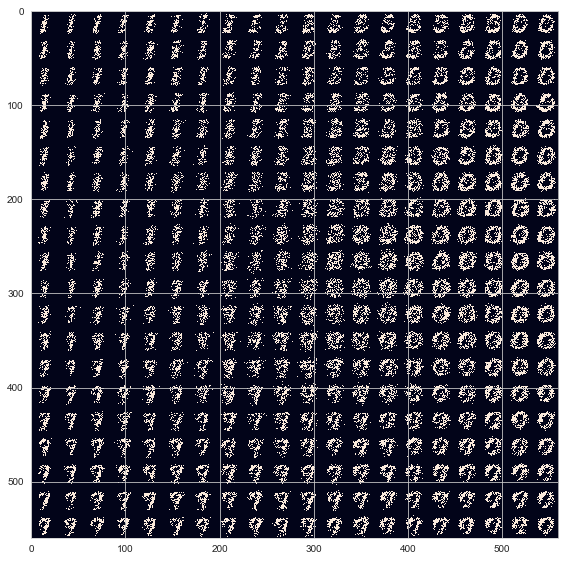

Iteration: 210 ELBO: -191.787 s/iter: 1.451e-01


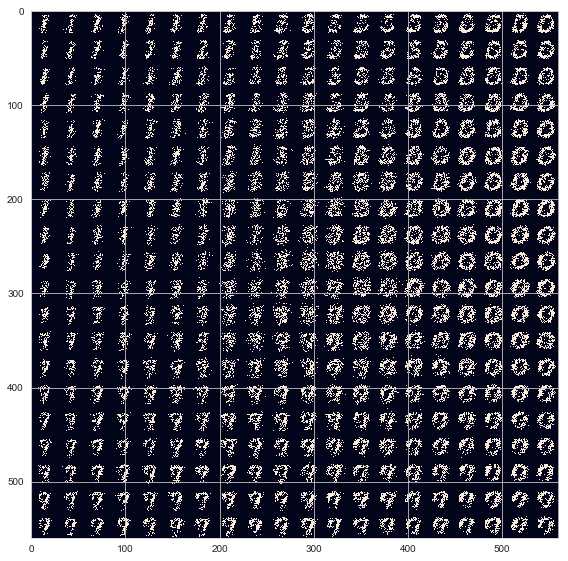

Iteration: 220 ELBO: -166.742 s/iter: 1.626e-01


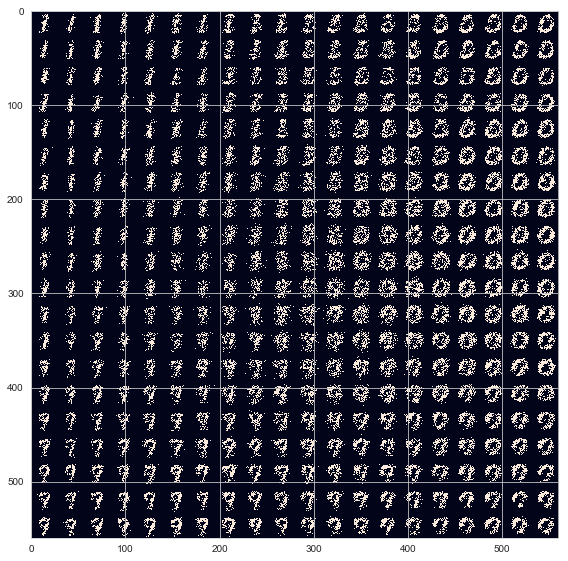

Iteration: 230 ELBO: -176.501 s/iter: 1.370e-01


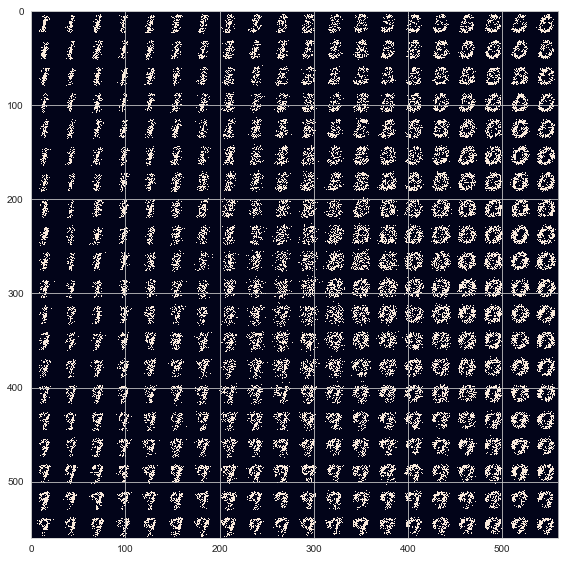

Iteration: 240 ELBO: -177.584 s/iter: 1.473e-01


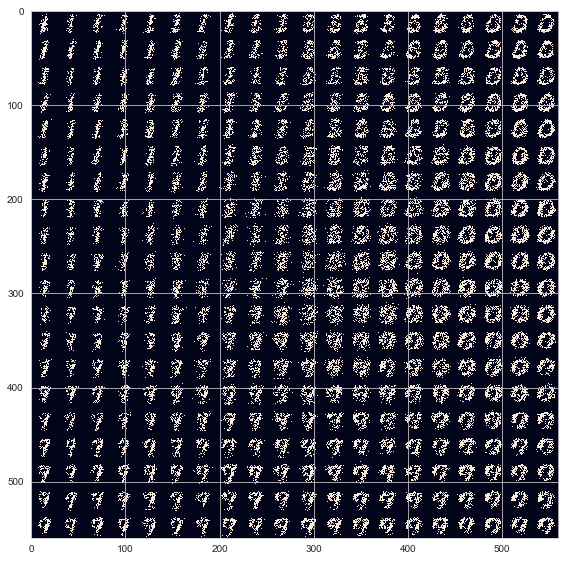

Iteration: 250 ELBO: -176.722 s/iter: 1.500e-01


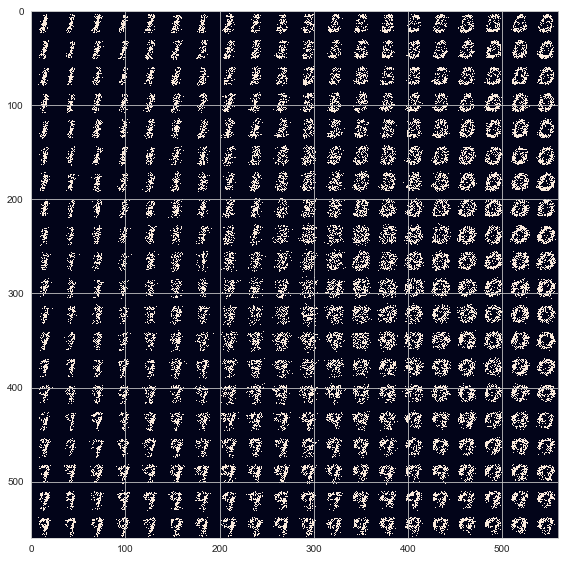

Iteration: 260 ELBO: -155.353 s/iter: 1.339e-01


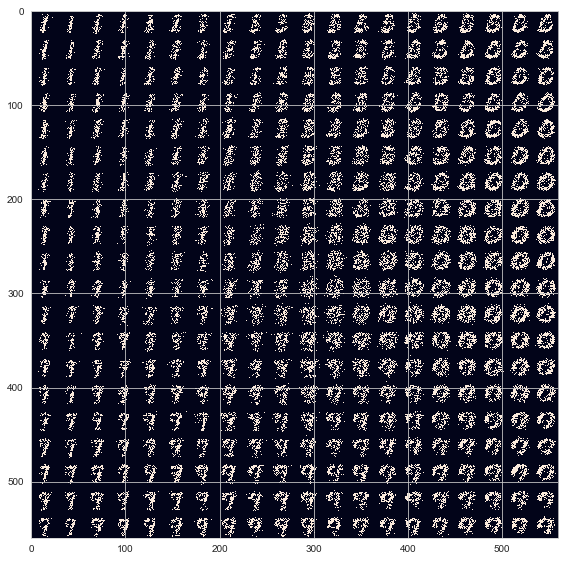

Iteration: 270 ELBO: -175.316 s/iter: 1.567e-01


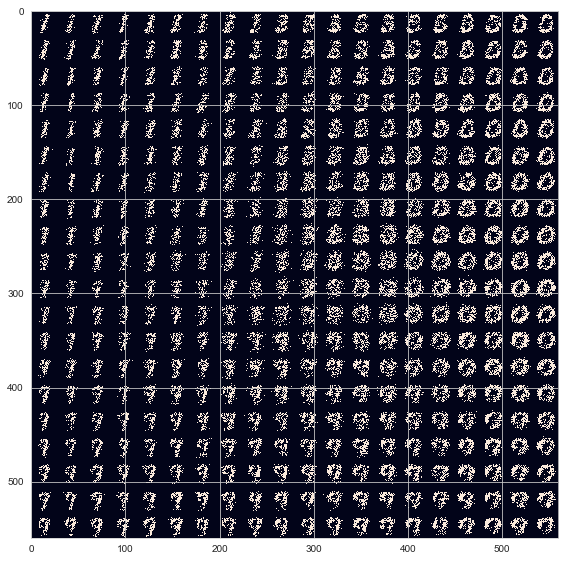

Iteration: 280 ELBO: -160.800 s/iter: 1.600e-01


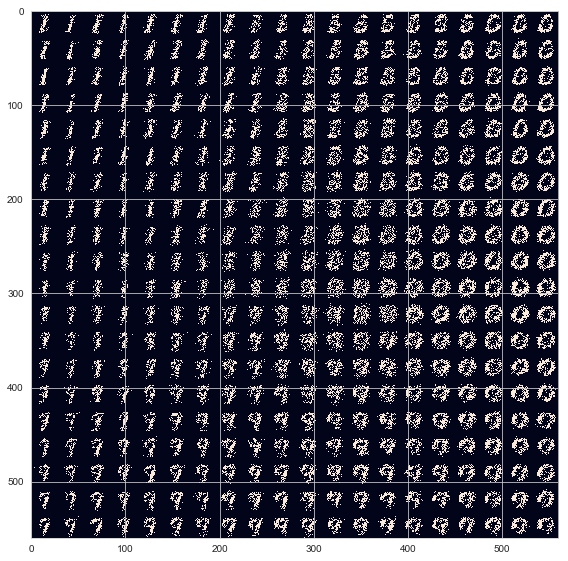

Iteration: 290 ELBO: -172.513 s/iter: 1.431e-01


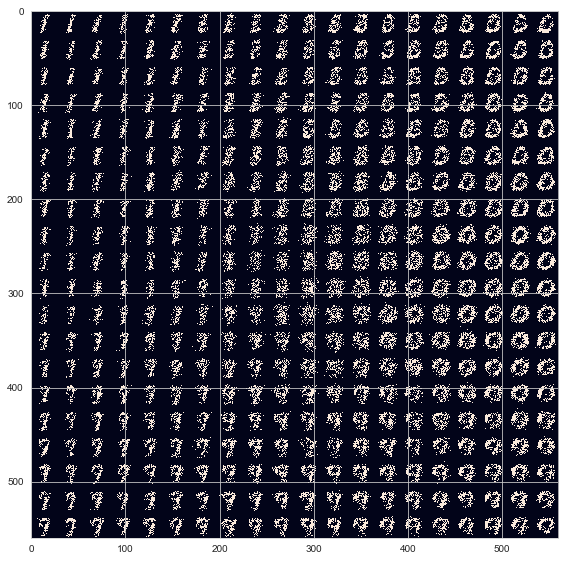

Iteration: 300 ELBO: -175.548 s/iter: 1.390e-01


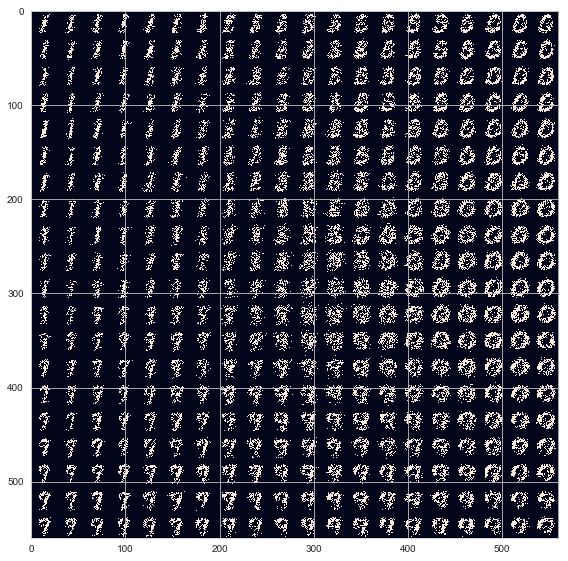

Iteration: 310 ELBO: -172.467 s/iter: 1.585e-01


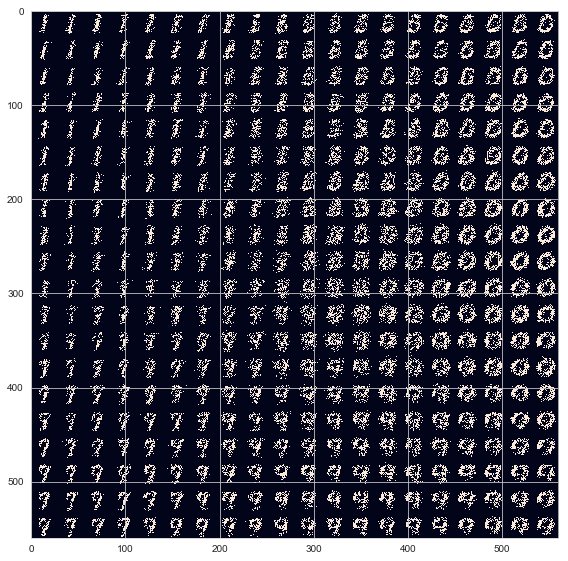

Iteration: 320 ELBO: -166.860 s/iter: 1.572e-01


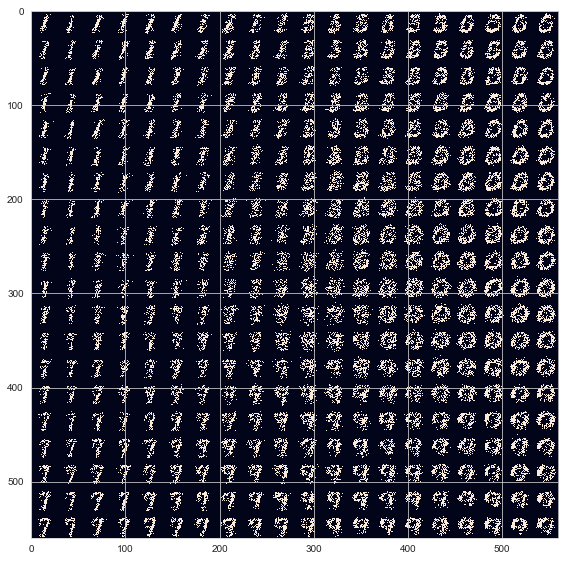

Iteration: 330 ELBO: -174.758 s/iter: 1.495e-01


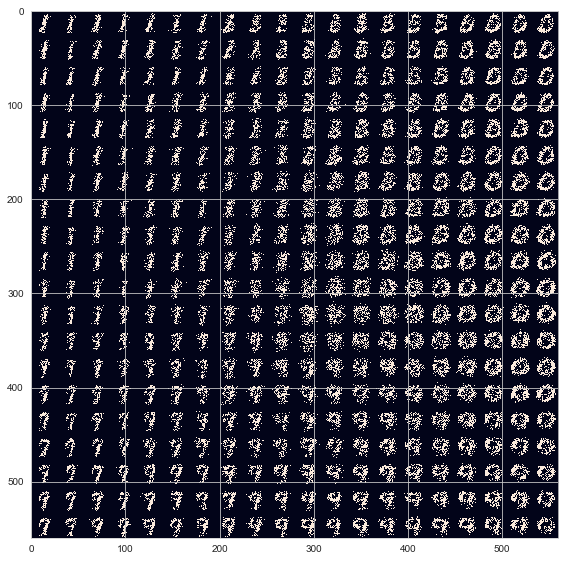

Iteration: 340 ELBO: -176.951 s/iter: 1.519e-01


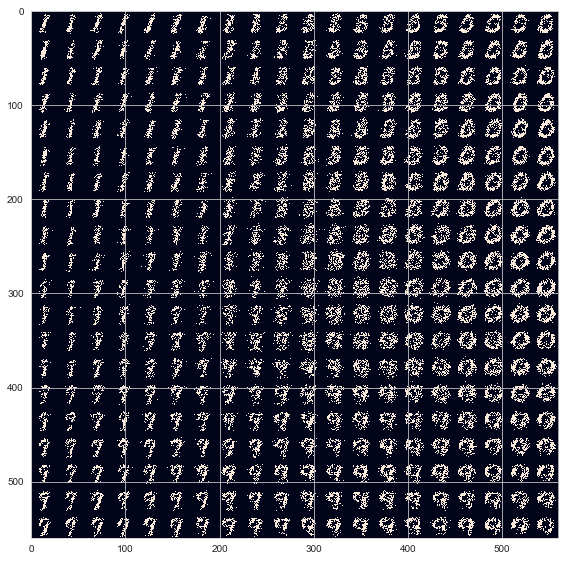

Iteration: 350 ELBO: -169.801 s/iter: 1.533e-01


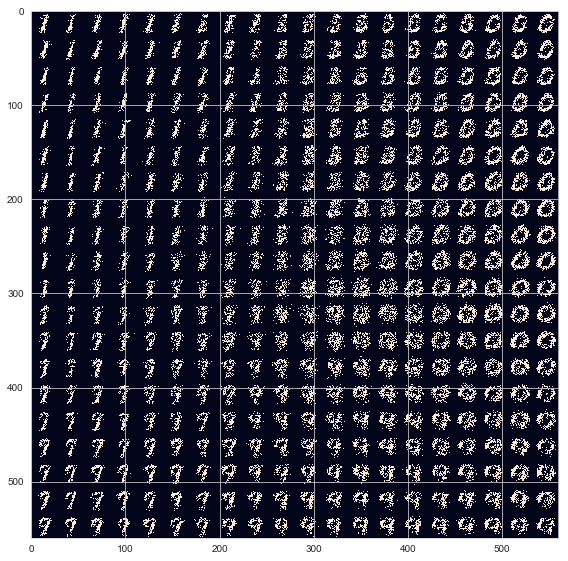

Iteration: 360 ELBO: -168.644 s/iter: 1.366e-01


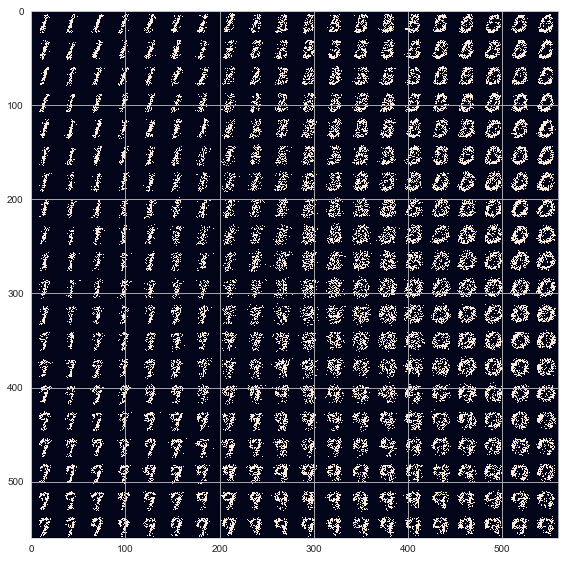

Iteration: 370 ELBO: -173.029 s/iter: 1.471e-01


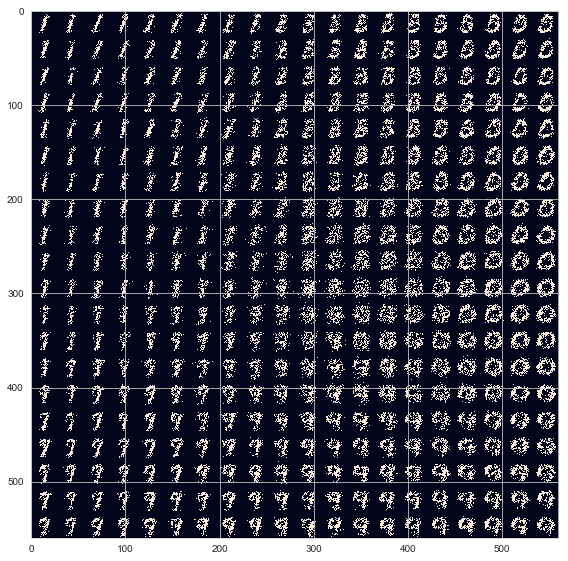

Iteration: 380 ELBO: -175.407 s/iter: 1.481e-01


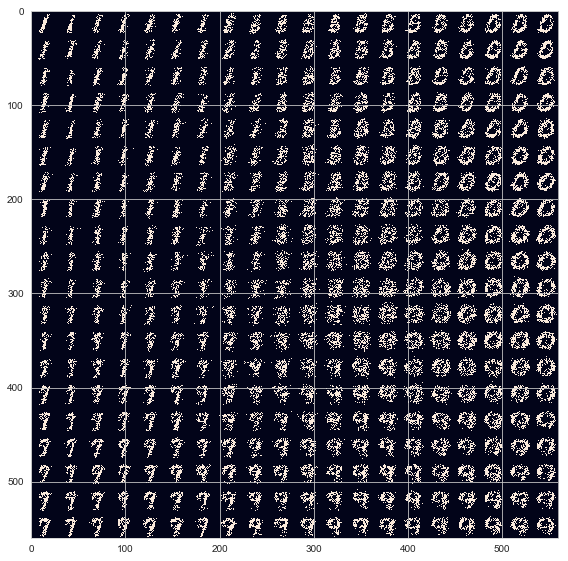

Iteration: 390 ELBO: -168.692 s/iter: 1.476e-01


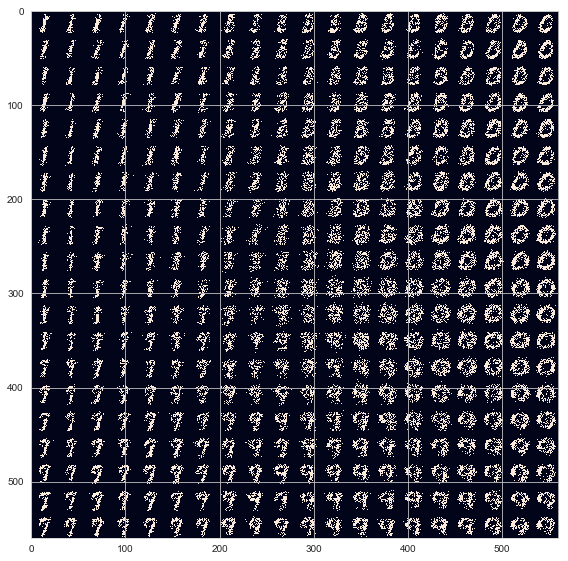

Iteration: 400 ELBO: -176.395 s/iter: 1.549e-01


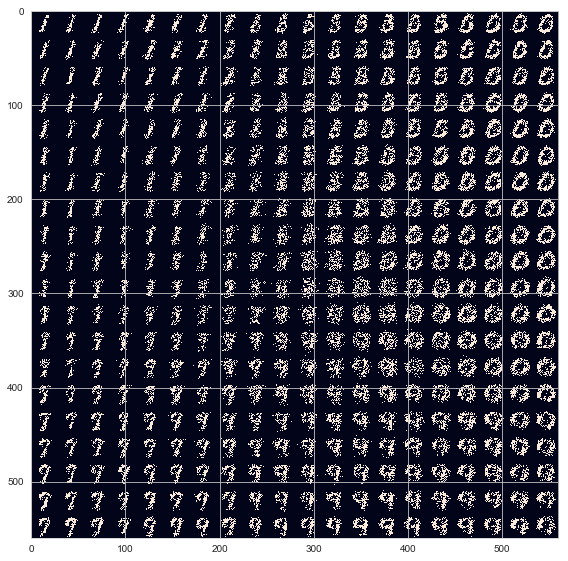

Iteration: 410 ELBO: -168.740 s/iter: 1.432e-01


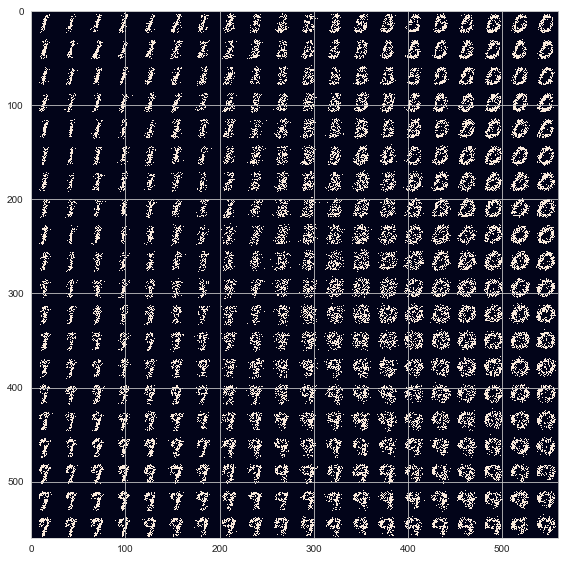

Iteration: 420 ELBO: -174.197 s/iter: 1.444e-01


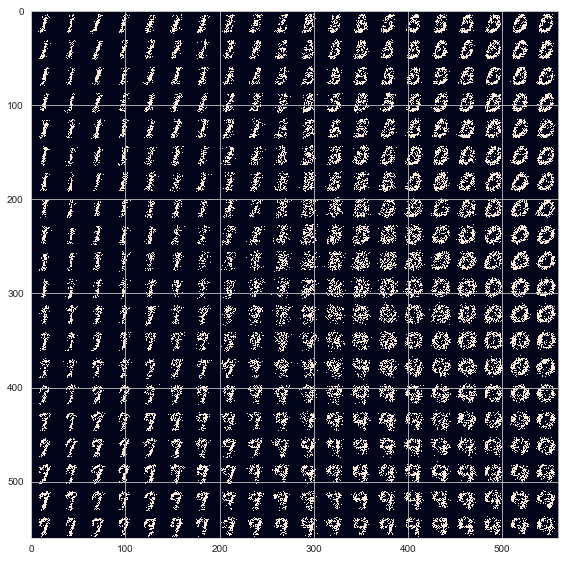

Iteration: 430 ELBO: -172.874 s/iter: 1.719e-01


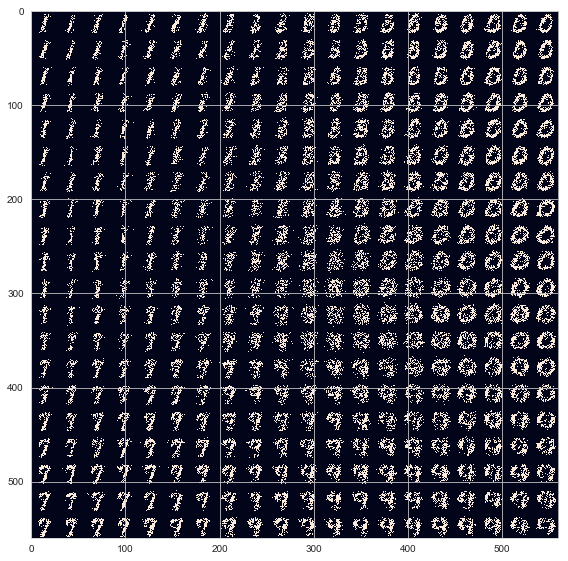

Iteration: 440 ELBO: -161.274 s/iter: 1.514e-01


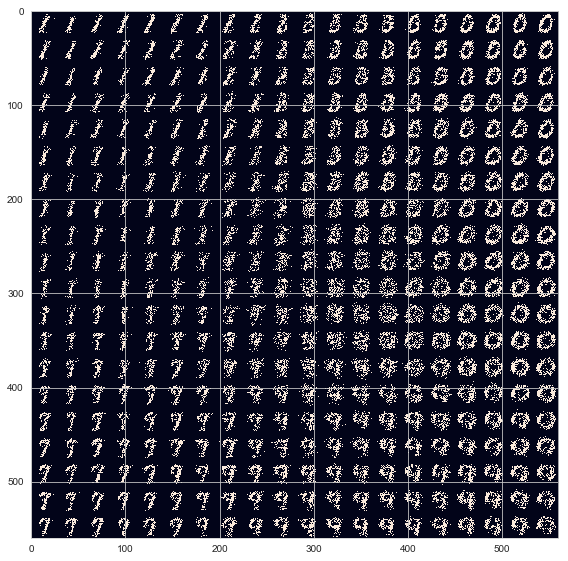

Iteration: 450 ELBO: -166.592 s/iter: 1.666e-01


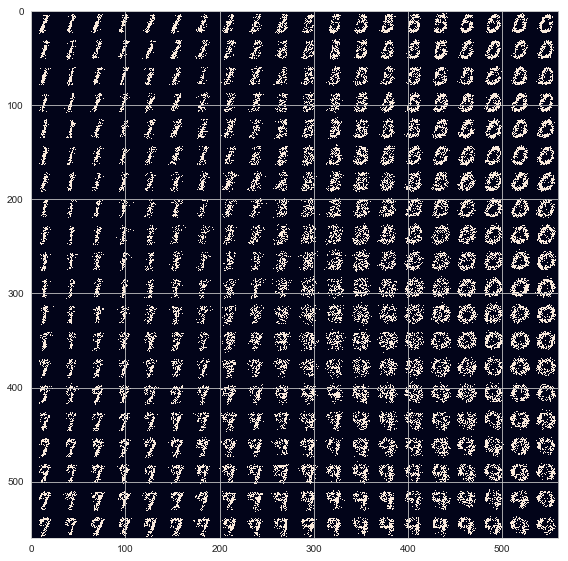

Iteration: 460 ELBO: -163.668 s/iter: 1.332e-01


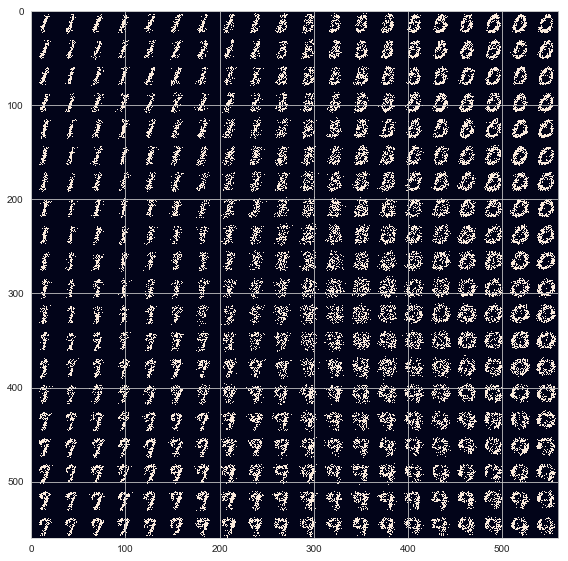

Iteration: 470 ELBO: -161.907 s/iter: 1.399e-01


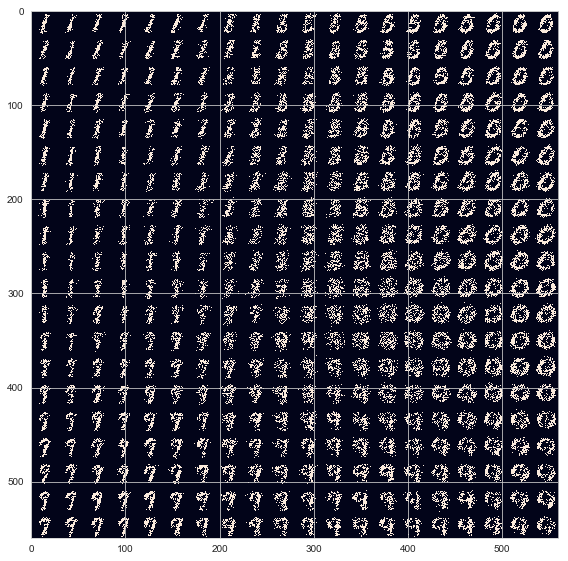

Iteration: 480 ELBO: -162.895 s/iter: 1.516e-01


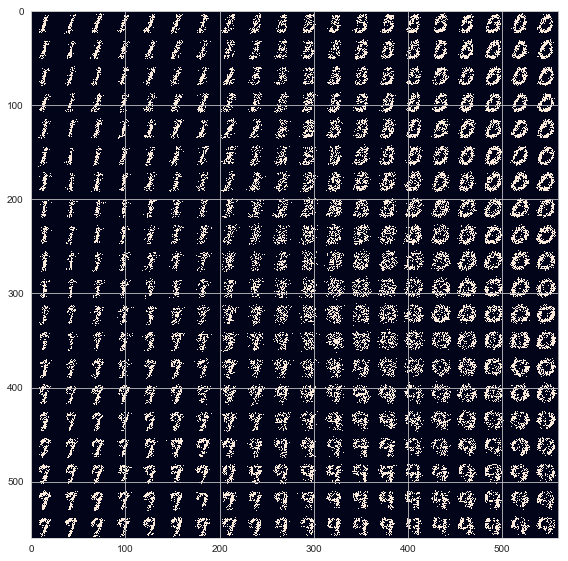

Iteration: 490 ELBO: -159.687 s/iter: 1.583e-01


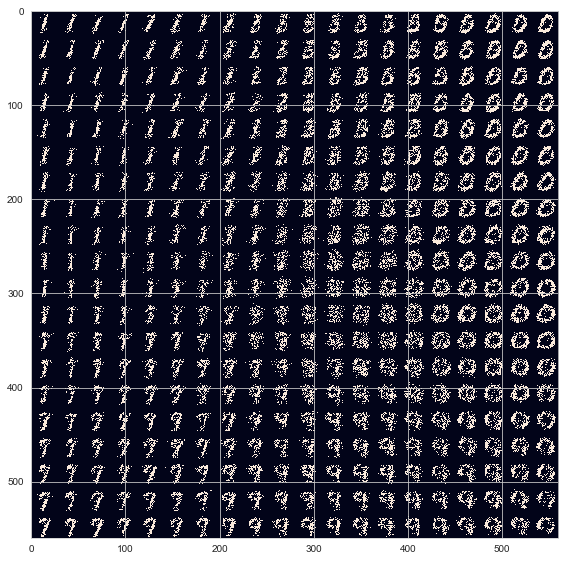

Iteration: 500 ELBO: -169.513 s/iter: 1.517e-01


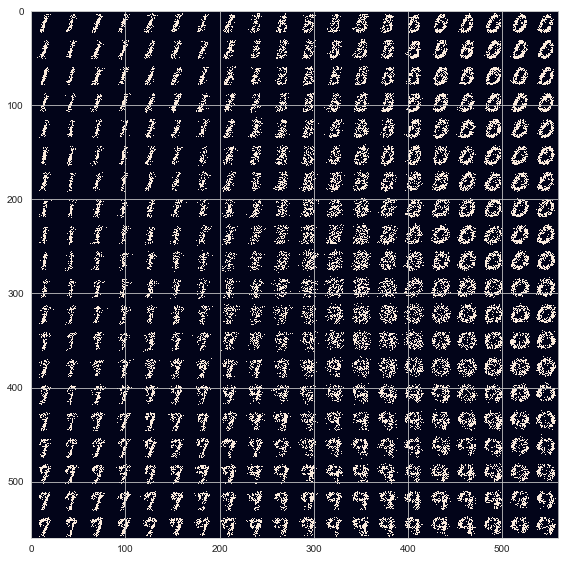

Iteration: 510 ELBO: -155.946 s/iter: 1.467e-01


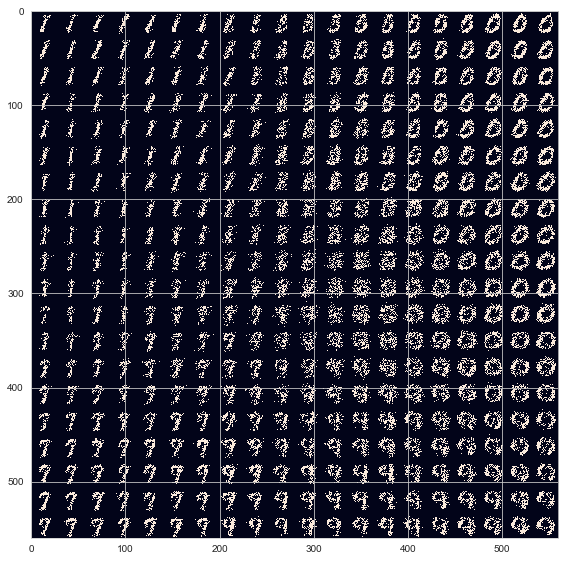

Iteration: 520 ELBO: -166.192 s/iter: 1.457e-01


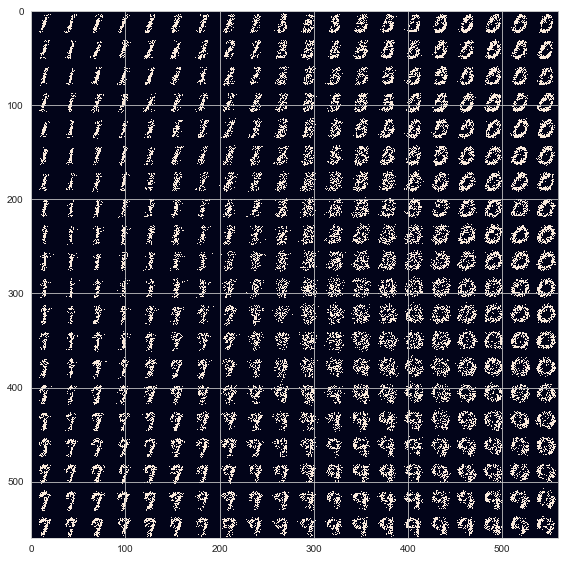

Iteration: 530 ELBO: -178.999 s/iter: 1.472e-01


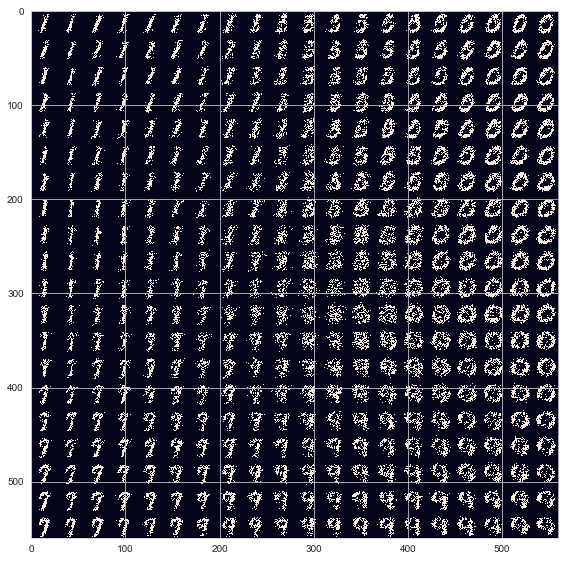

Iteration: 540 ELBO: -162.856 s/iter: 1.366e-01


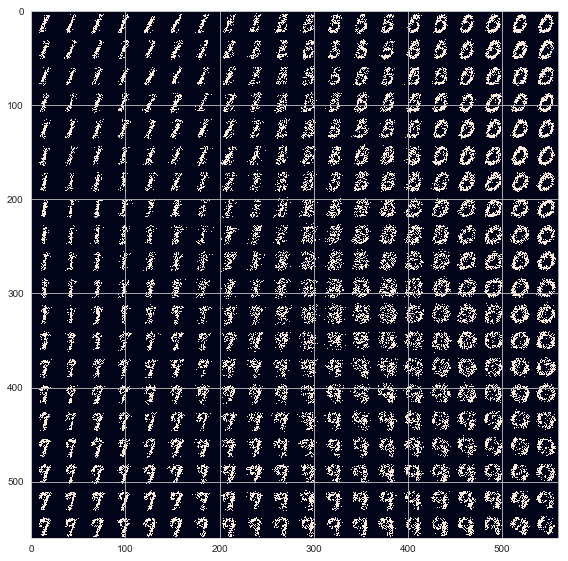

Iteration: 550 ELBO: -163.954 s/iter: 1.516e-01


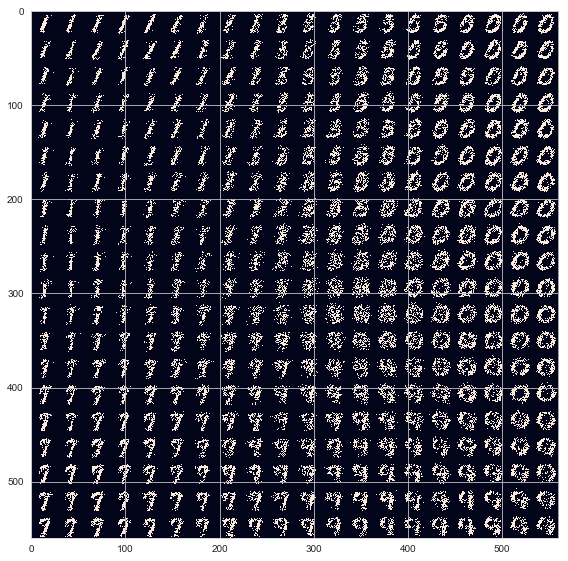

Iteration: 560 ELBO: -178.081 s/iter: 1.447e-01


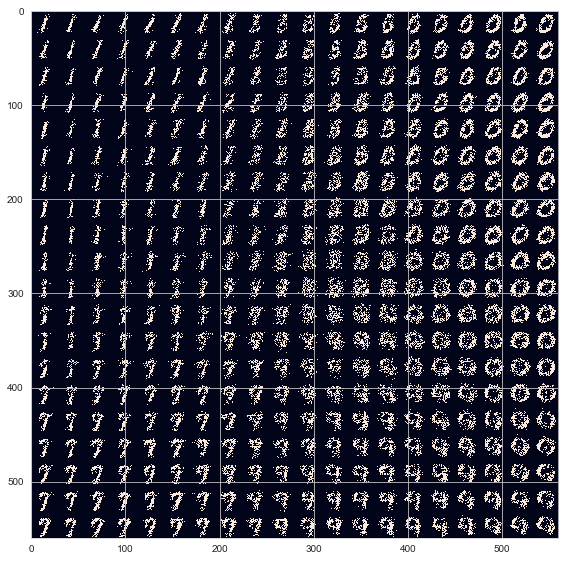

Iteration: 570 ELBO: -169.588 s/iter: 1.484e-01


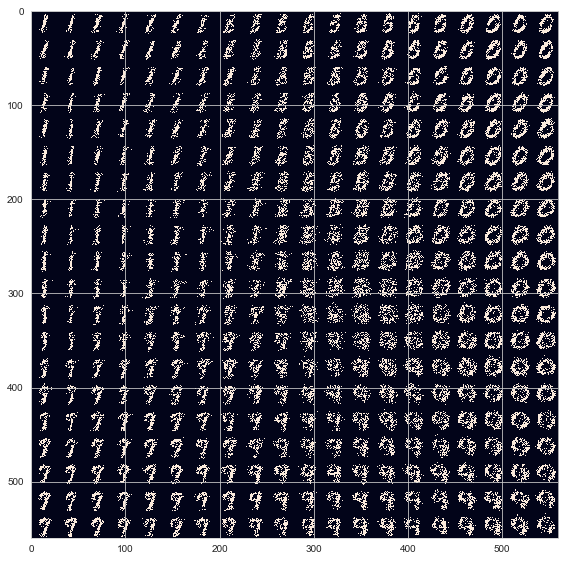

Iteration: 580 ELBO: -171.739 s/iter: 1.669e-01


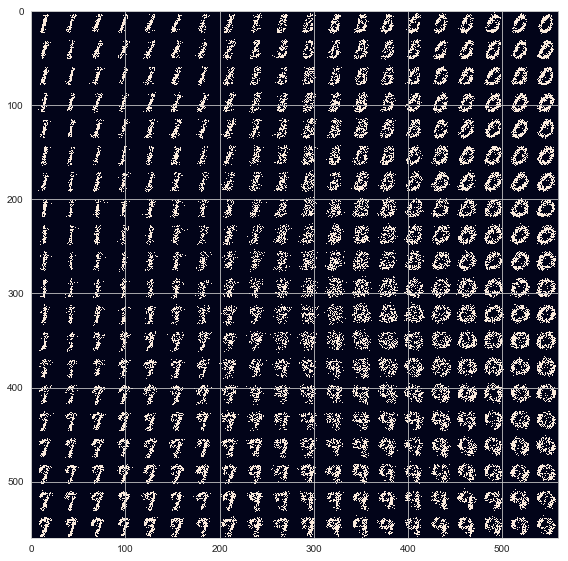

Iteration: 590 ELBO: -167.679 s/iter: 1.448e-01


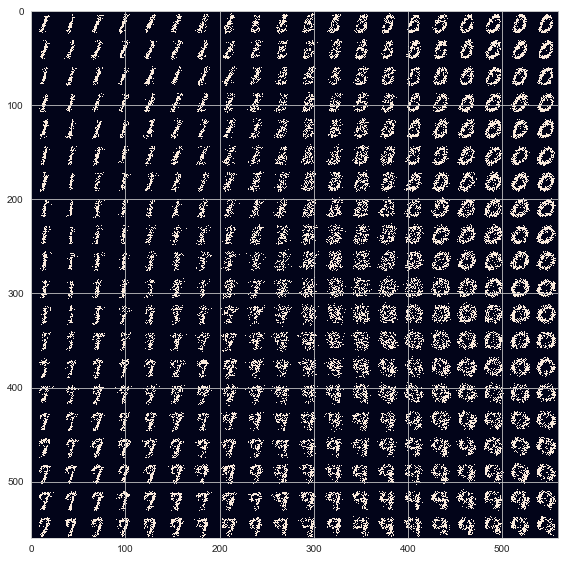

Iteration: 600 ELBO: -164.485 s/iter: 1.553e-01


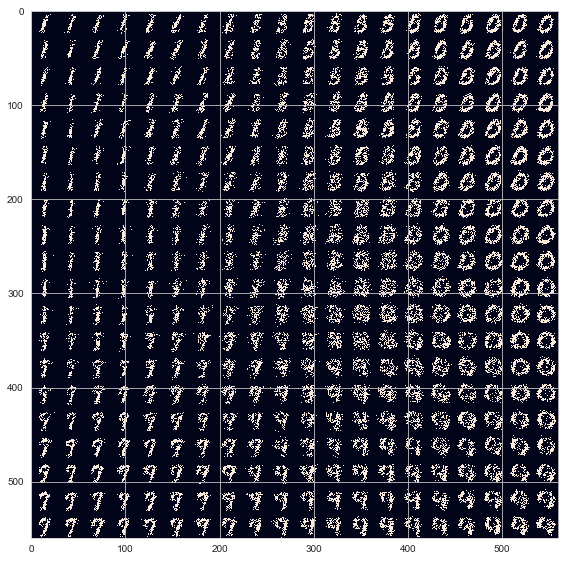

Iteration: 610 ELBO: -160.644 s/iter: 1.394e-01


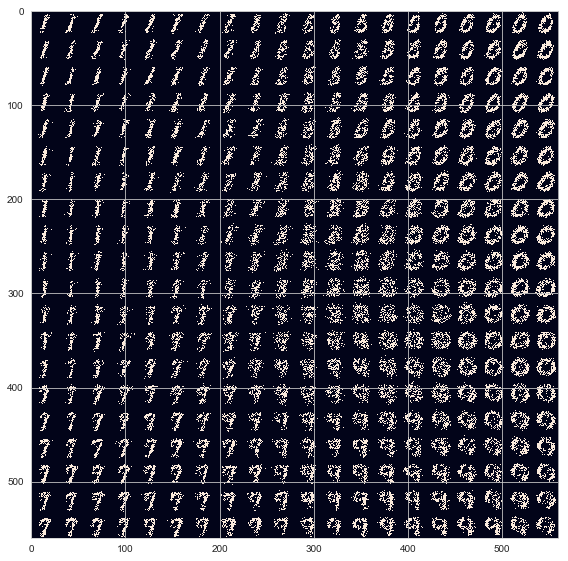

Iteration: 620 ELBO: -170.710 s/iter: 1.494e-01


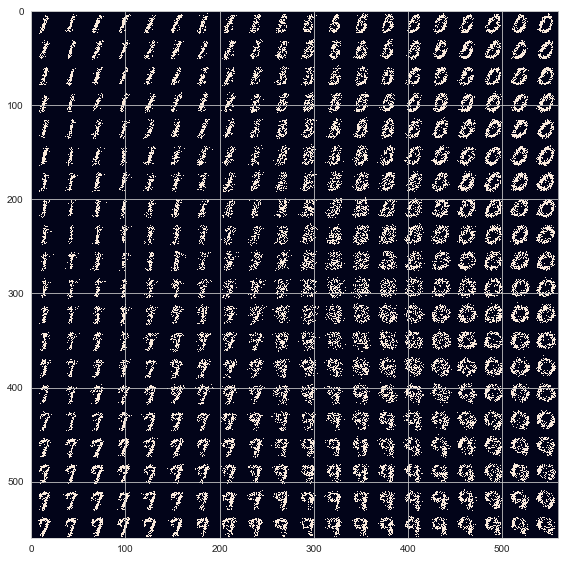

Iteration: 630 ELBO: -164.247 s/iter: 1.436e-01


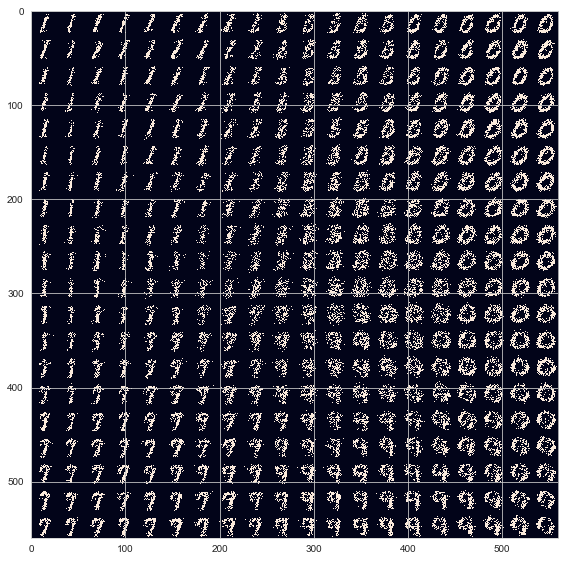

Iteration: 640 ELBO: -161.685 s/iter: 1.406e-01


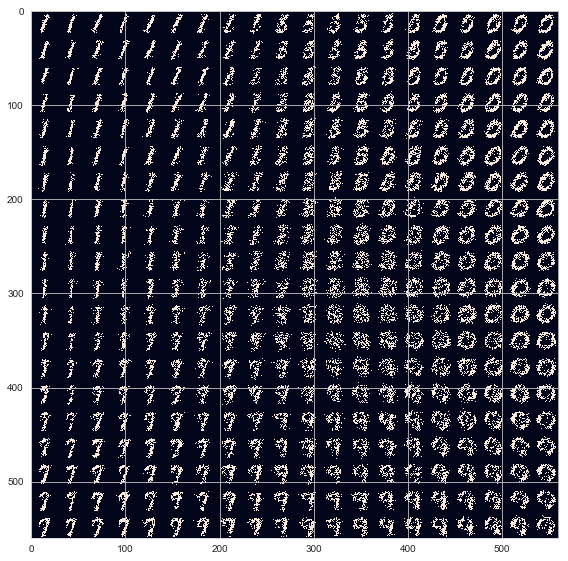

Iteration: 650 ELBO: -158.076 s/iter: 1.394e-01


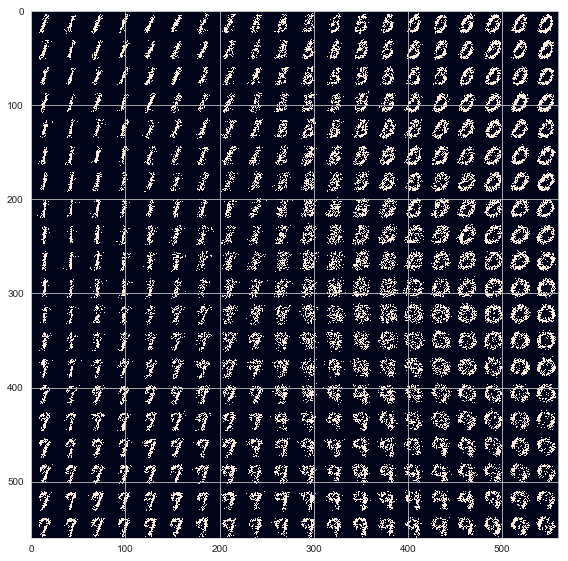

Iteration: 660 ELBO: -158.334 s/iter: 1.355e-01


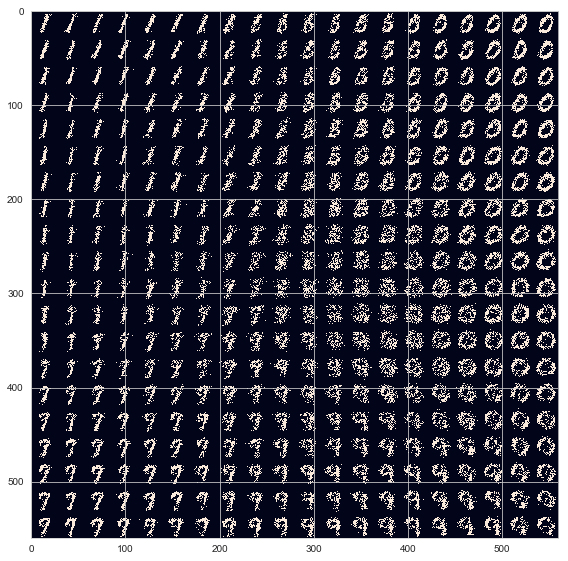

Iteration: 670 ELBO: -166.552 s/iter: 1.557e-01


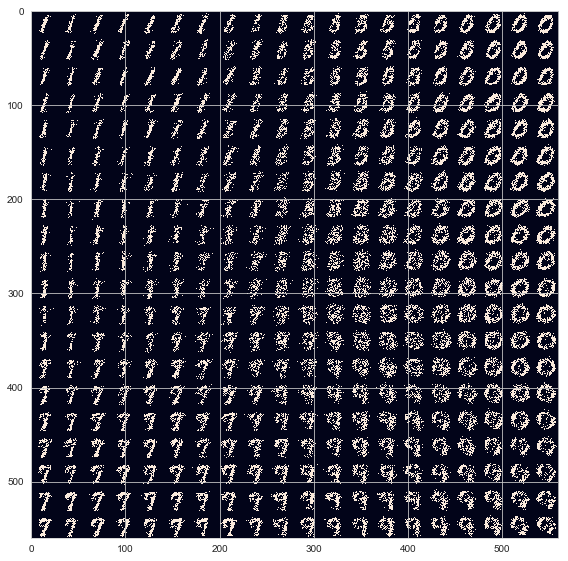

Iteration: 680 ELBO: -166.291 s/iter: 1.353e-01


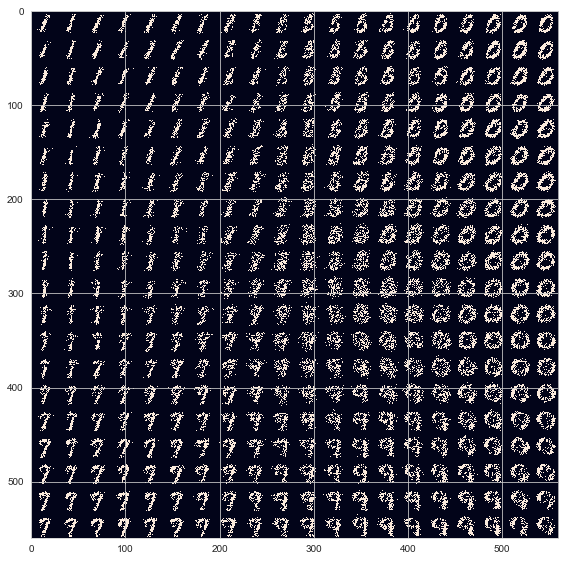

Iteration: 690 ELBO: -155.120 s/iter: 1.667e-01


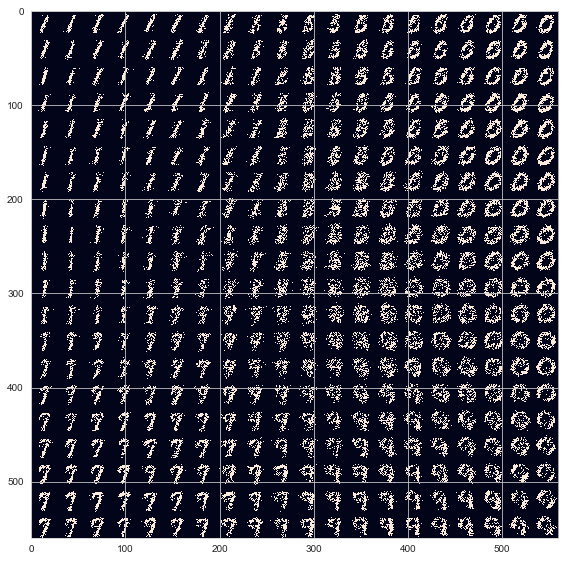

Iteration: 700 ELBO: -180.027 s/iter: 1.456e-01


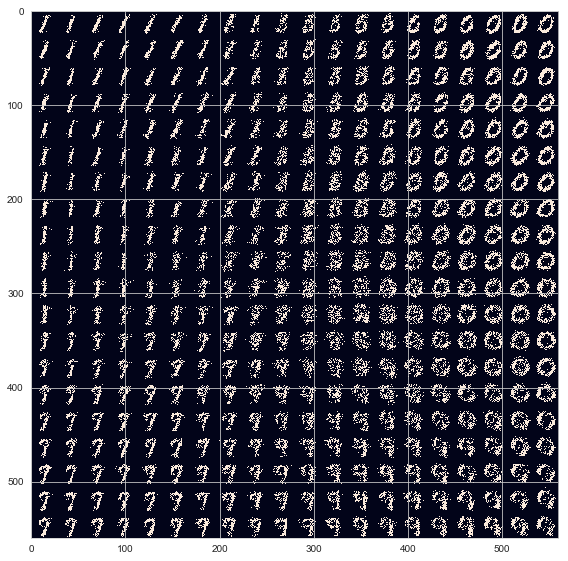

Iteration: 710 ELBO: -165.795 s/iter: 1.459e-01


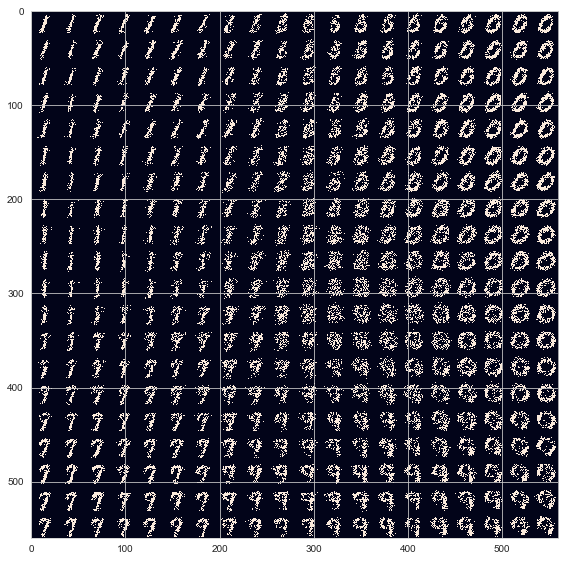

Iteration: 720 ELBO: -167.035 s/iter: 1.422e-01


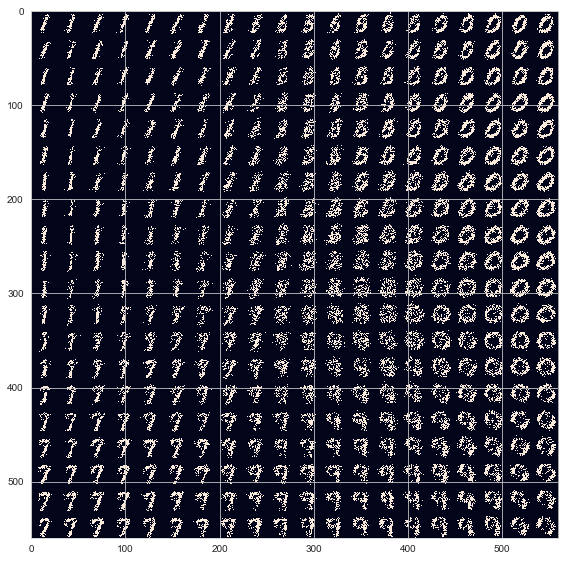

Iteration: 730 ELBO: -161.683 s/iter: 1.516e-01


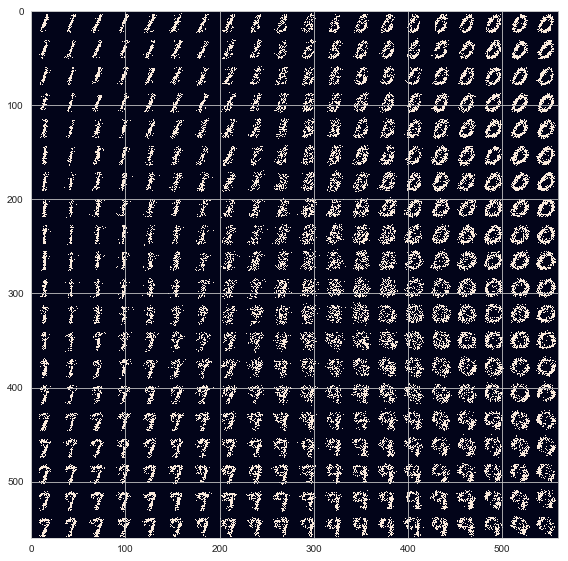

Iteration: 740 ELBO: -160.154 s/iter: 1.410e-01


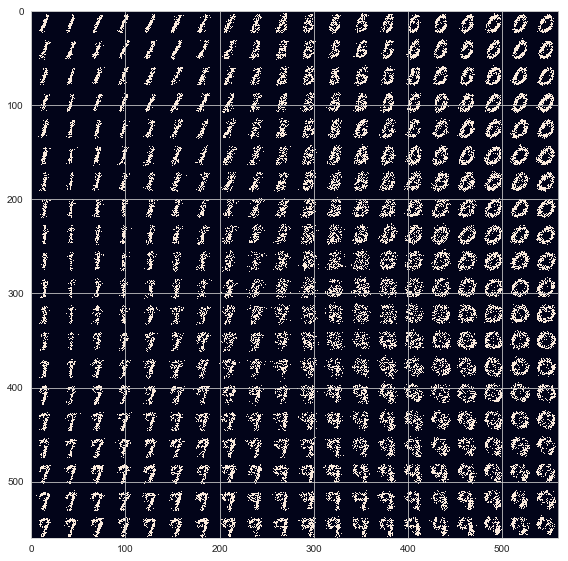

Iteration: 750 ELBO: -165.548 s/iter: 1.422e-01


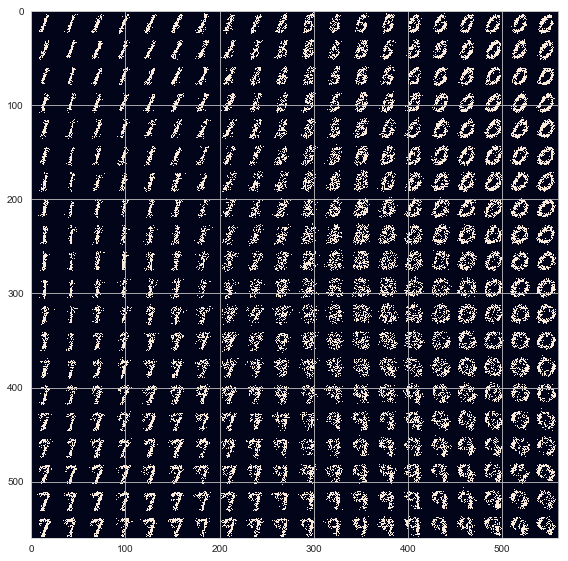

Iteration: 760 ELBO: -154.731 s/iter: 1.561e-01


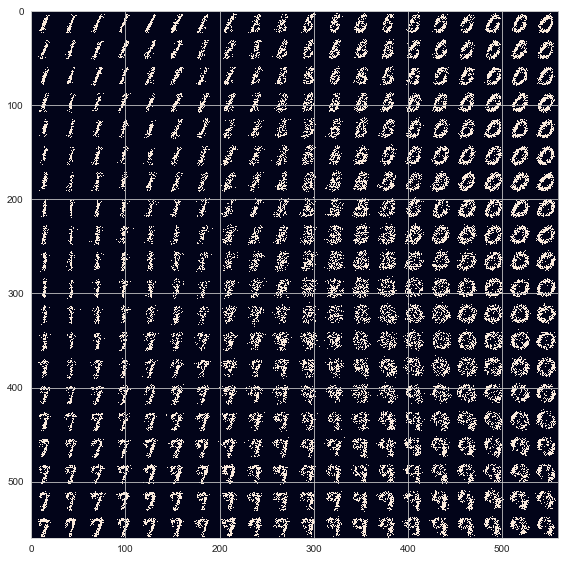

Iteration: 770 ELBO: -167.850 s/iter: 1.485e-01


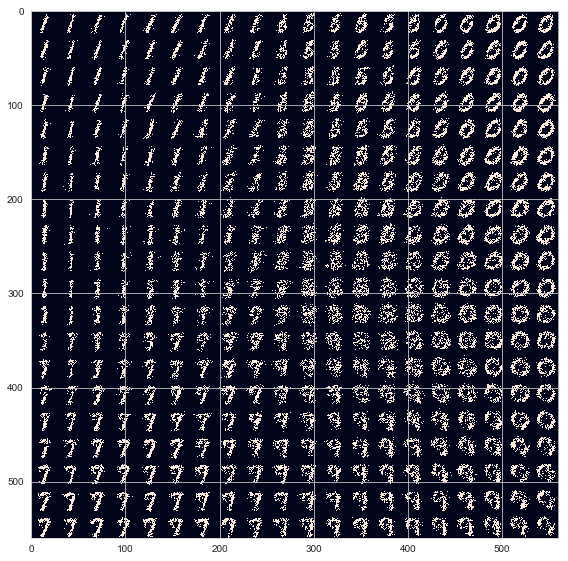

Iteration: 780 ELBO: -172.668 s/iter: 1.391e-01


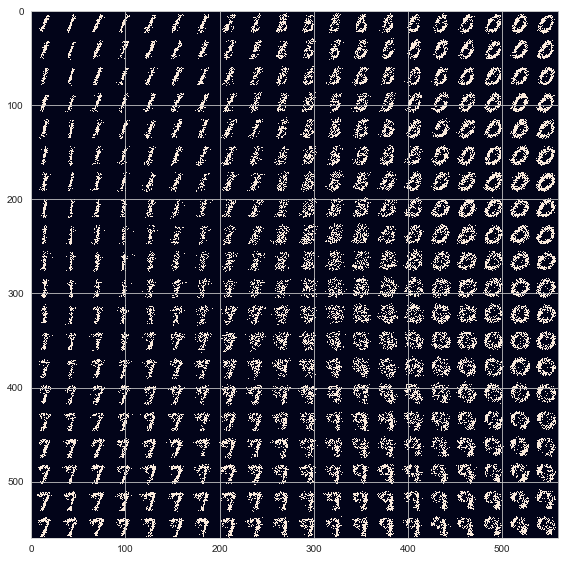

Iteration: 790 ELBO: -152.179 s/iter: 1.522e-01


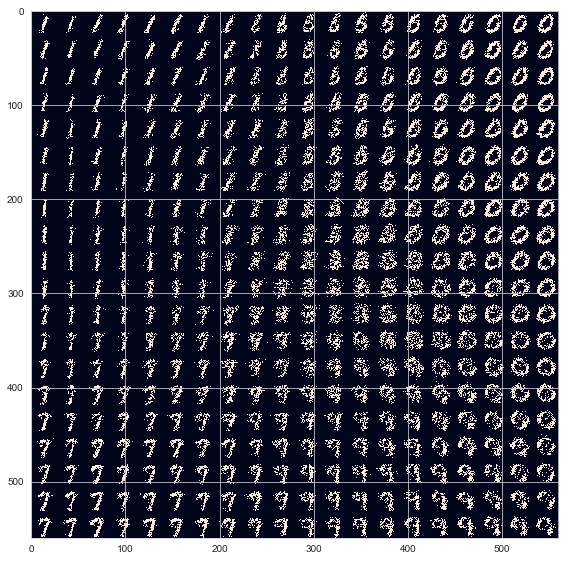

Iteration: 800 ELBO: -168.282 s/iter: 1.412e-01


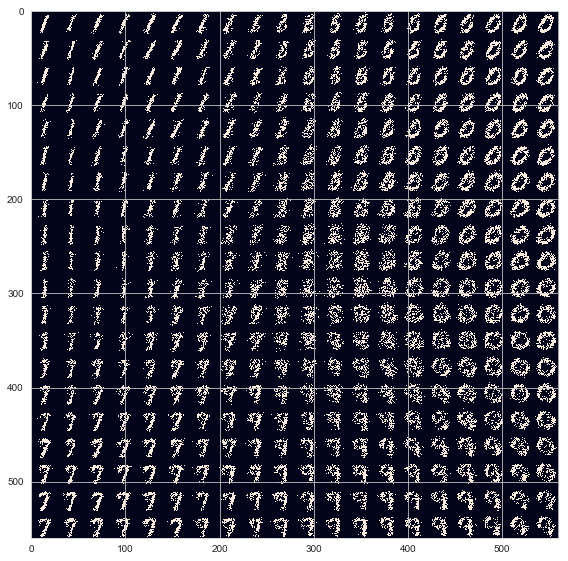

Iteration: 810 ELBO: -163.424 s/iter: 1.378e-01


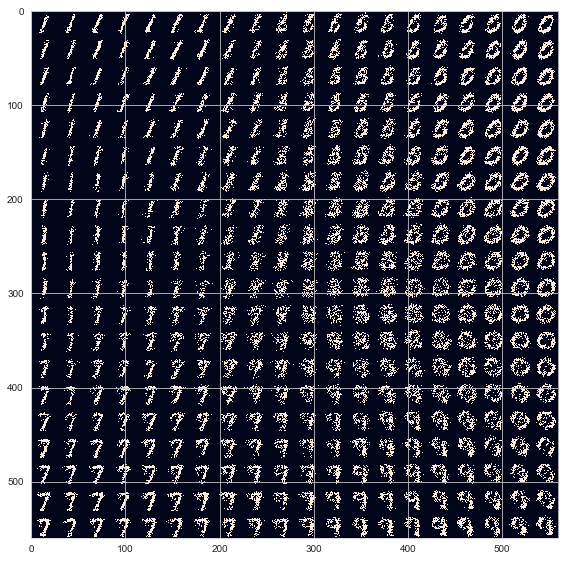

Iteration: 820 ELBO: -172.422 s/iter: 1.394e-01


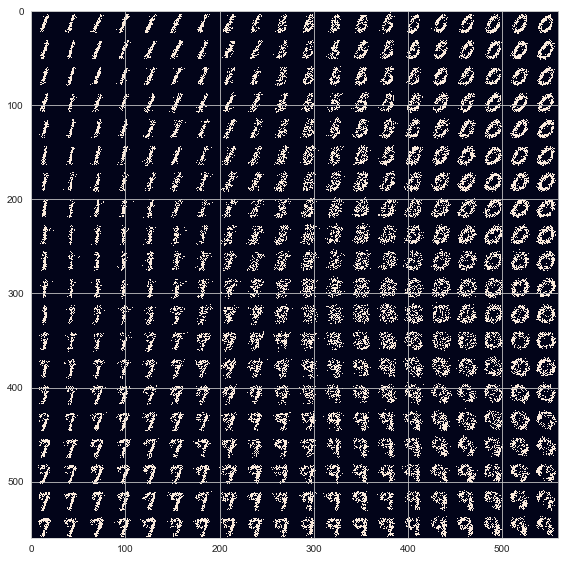

Iteration: 830 ELBO: -157.362 s/iter: 1.395e-01


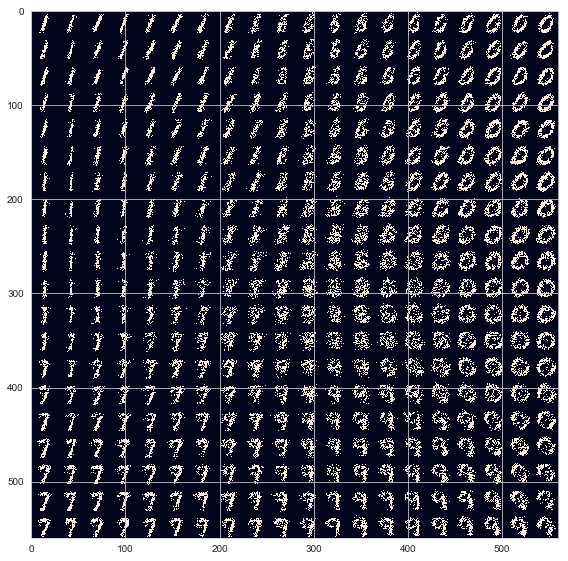

Iteration: 840 ELBO: -152.905 s/iter: 1.552e-01


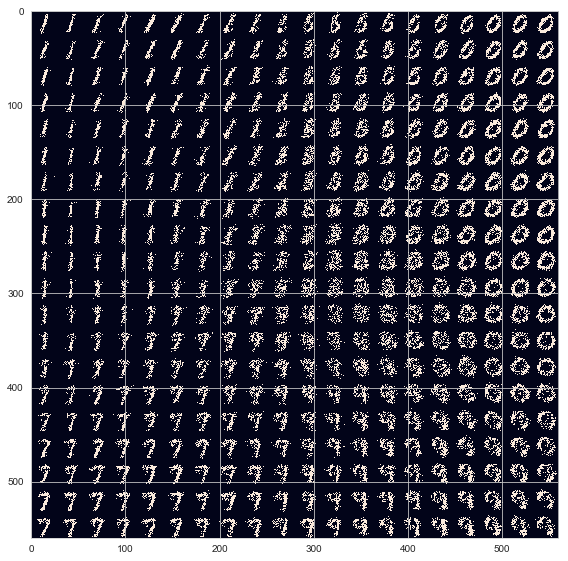

Iteration: 850 ELBO: -161.440 s/iter: 1.471e-01


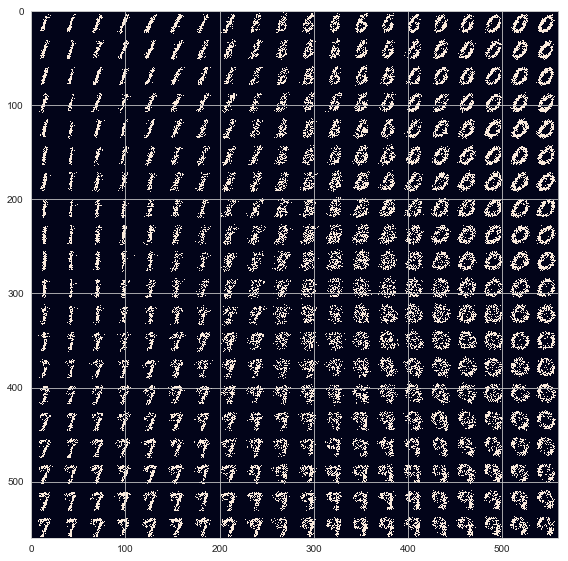

Iteration: 860 ELBO: -159.465 s/iter: 1.791e-01


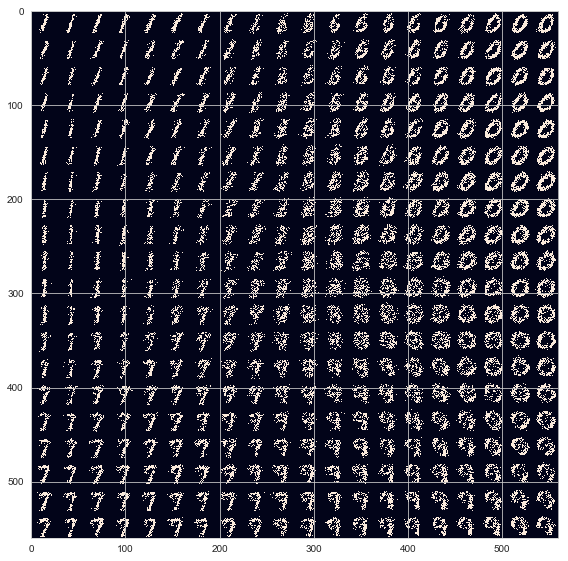

Iteration: 870 ELBO: -176.340 s/iter: 1.416e-01


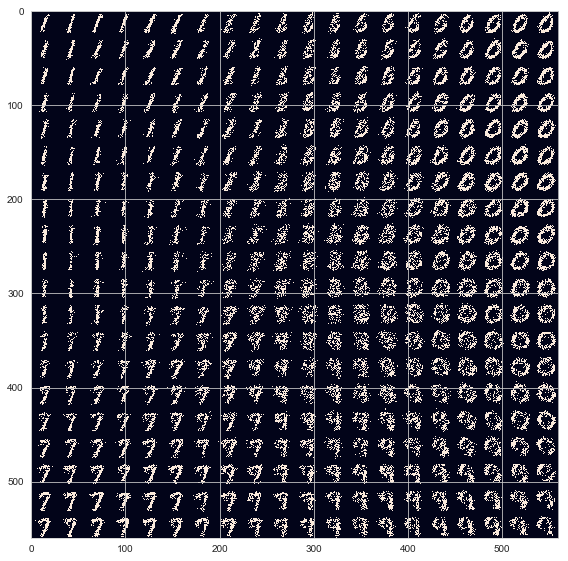

Iteration: 880 ELBO: -162.893 s/iter: 1.514e-01


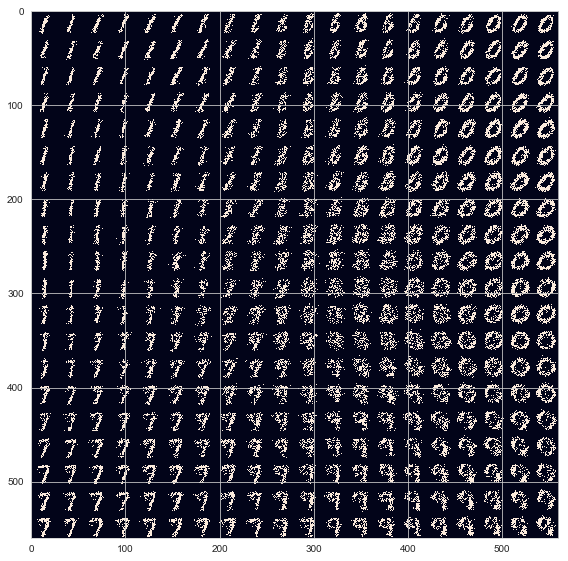

Iteration: 890 ELBO: -161.260 s/iter: 1.353e-01


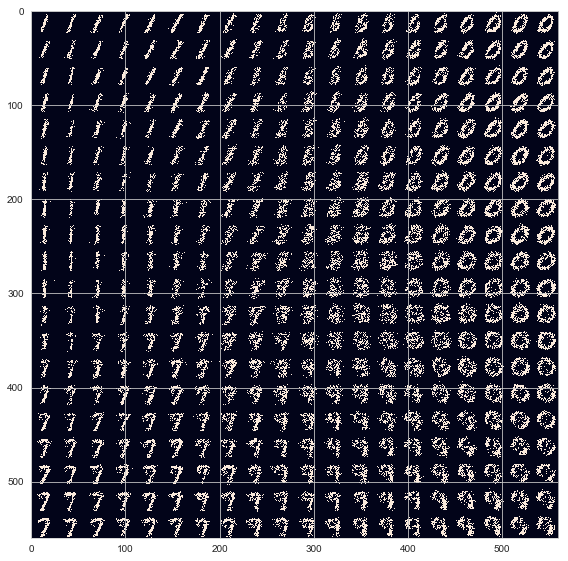

Iteration: 900 ELBO: -154.596 s/iter: 1.380e-01


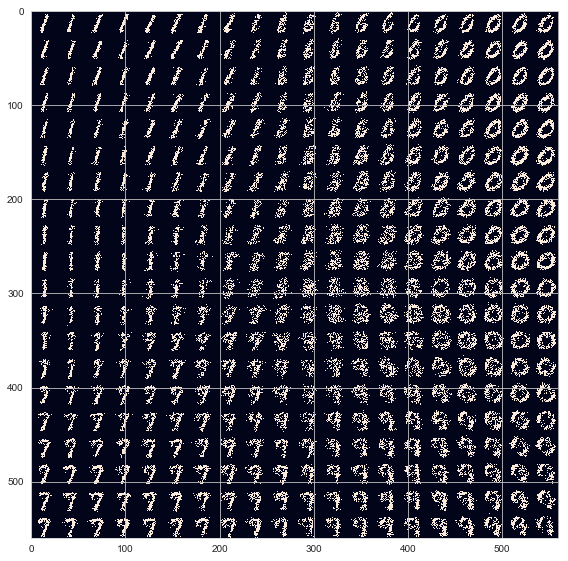

Iteration: 910 ELBO: -151.012 s/iter: 1.466e-01


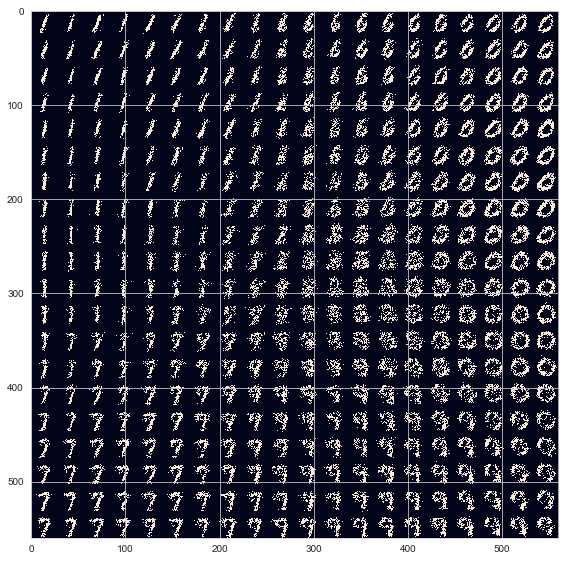

Iteration: 920 ELBO: -159.308 s/iter: 1.434e-01


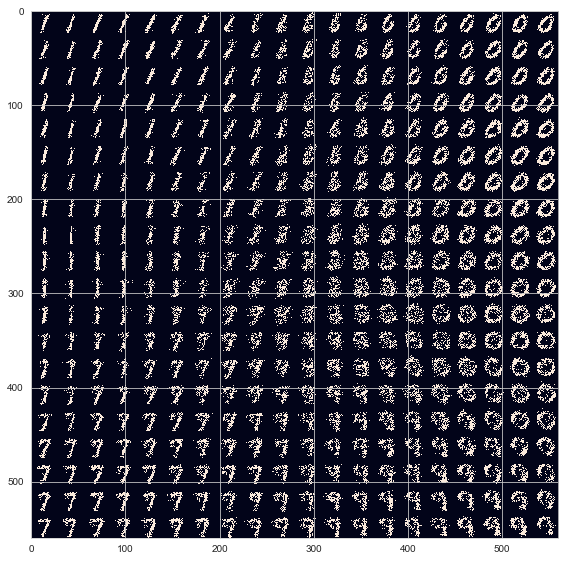

Iteration: 930 ELBO: -155.448 s/iter: 1.314e-01


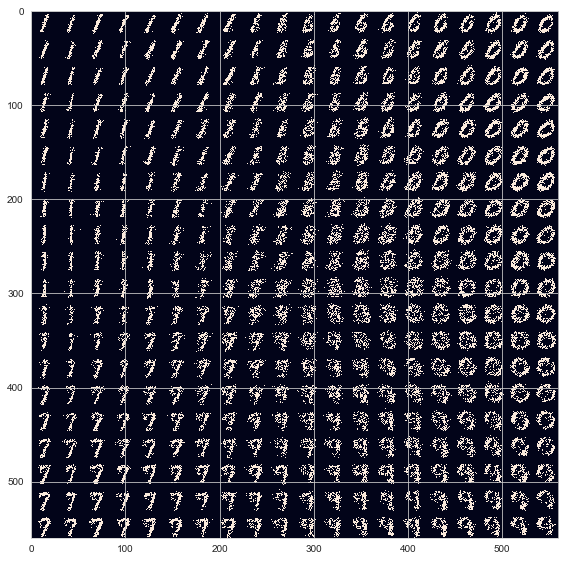

Iteration: 940 ELBO: -155.789 s/iter: 1.453e-01


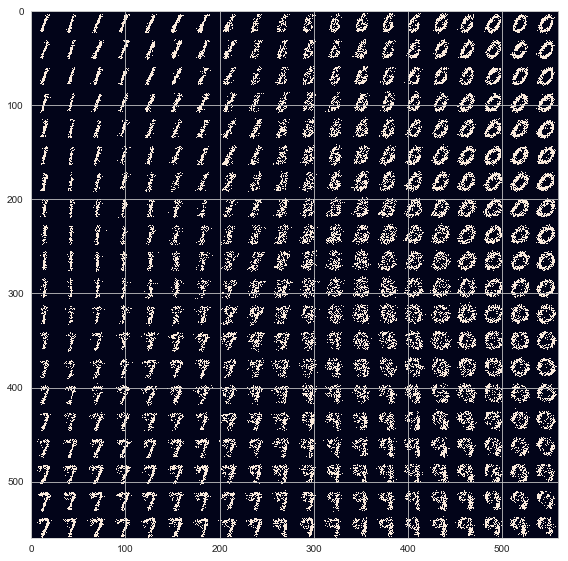

Iteration: 950 ELBO: -161.987 s/iter: 1.534e-01


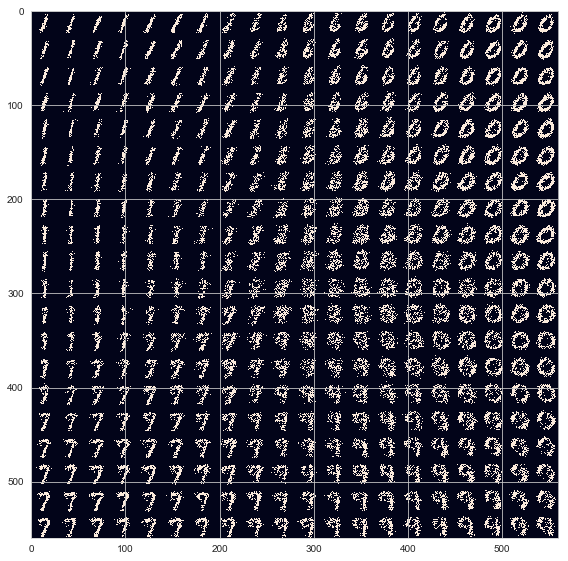

Iteration: 960 ELBO: -167.927 s/iter: 1.498e-01


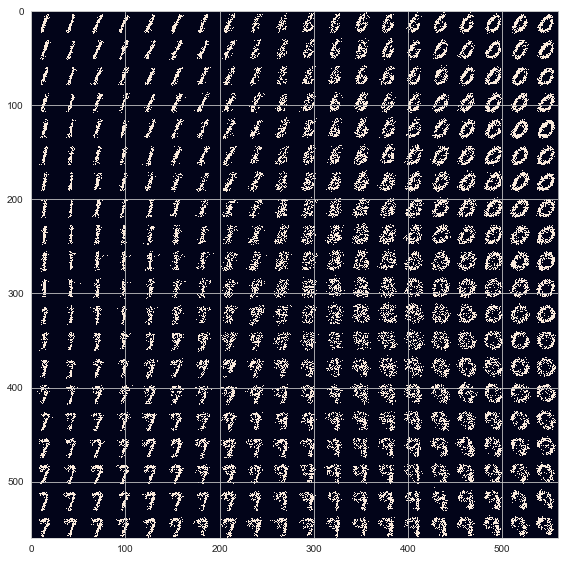

Iteration: 970 ELBO: -155.439 s/iter: 1.350e-01


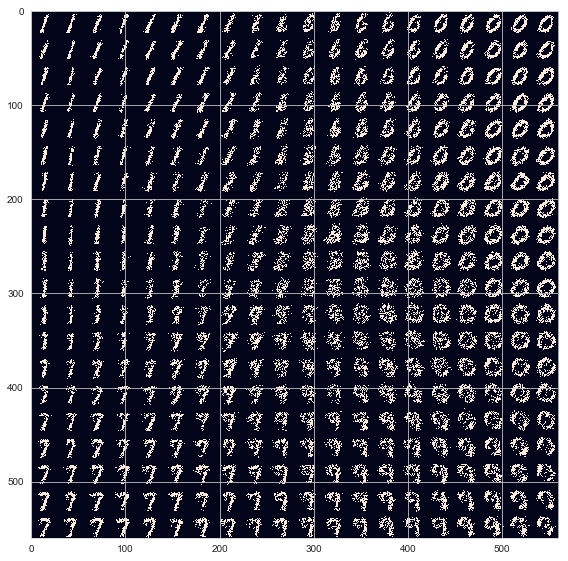

Iteration: 980 ELBO: -154.107 s/iter: 1.449e-01


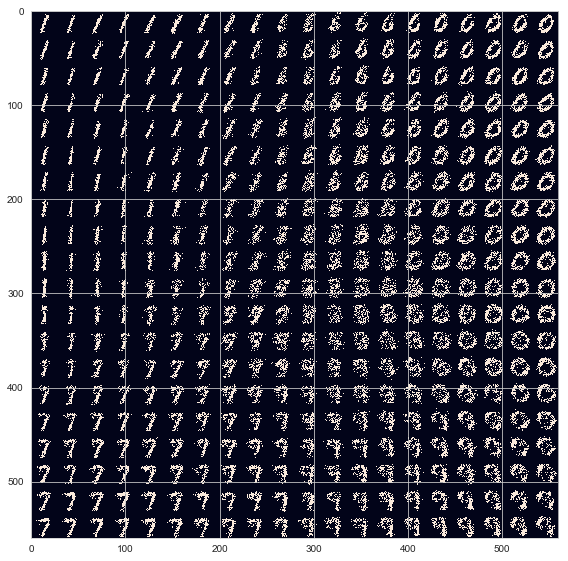

Iteration: 990 ELBO: -154.781 s/iter: 1.484e-01


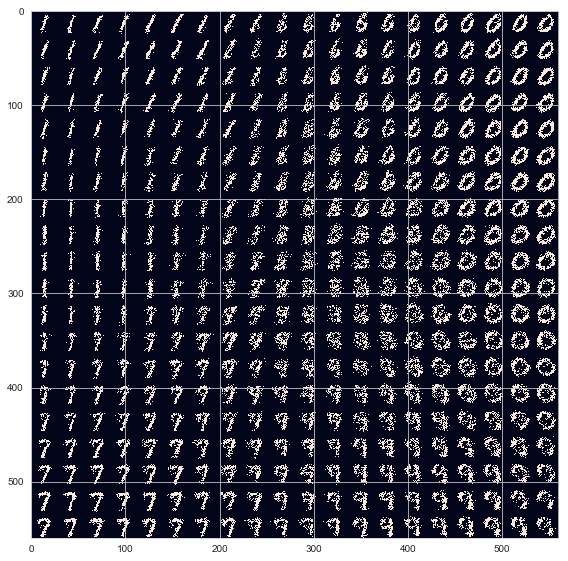

In [24]:
def main(_):
  # A bunch of lines to prepare the environment
  if tf.gfile.Exists(vae_global_parameters['logdir']):
    tf.gfile.DeleteRecursively(vae_global_parameters['logdir'])
  tf.gfile.MakeDirs(vae_global_parameters['logdir'])
  old_v = tf.logging.get_verbosity()
  tf.logging.set_verbosity(tf.logging.ERROR)
  os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
    
  # Let's train this!
  train()
    
  #tf.logging.set_verbosity(old_v)

if __name__ == '__main__':
  main(_)